In [1]:
import numpy as np
import timeit
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import lambertw
import math
import pickle
import sys
from numba import njit, prange
from scipy.stats import norm
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
import seaborn as sns
import time

ffspeed = 45
capacity = 9000

user_params = {'lambda': 3, 'gamma': 2,'hetero':1.6}
Tstep = 1 # discretization in one day 
deltaP = 0.05
RBTD = 100
Plot = True
seed_Value = 333
verbose = True
 # Policy: False, uniform, personalizedCap, personalizedNocap
numOfusers = 7500
numOfdays = 30
unusual = {"unusual":False,'day':10,
               "read":'Trinitytt.npy','ctrlprice':2.63,
               'regulatesTime':415,'regulateeTime':557,
           "dropstime":360,"dropetime":480,"FTC": 0.05,"AR":0.0}
storeTT = {'flag':False,"ttfilename":'Trinitylumptt'}

def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

@njit
def V1(x):
    return np.square(1 - x / capacity) * ffspeed

# (1-n/1000)^2*ffspeed*n, if the flow is larger than this, it is congested
@njit
def V(x):
    if isinstance(x, list):
        return [np.square(1 - i / capacity) * ffspeed for i in x]
    else:
        return np.square(1 - x / capacity) * ffspeed

'''
    The function evaluate the actual utility which users have experienced on day d for the choice they made 
    or the estimated utility for choices they didn't make. 
    This means they are considering both the choices they made and the ones they didn't make.
'''
@njit(parallel=True)
def estimated_TT(all_time_matrix,  time_list, car_number, _Accumulation, dist, ffspeed):
    user_number = all_time_matrix.shape[0]
    departure_steps = all_time_matrix.shape[1]
    user_in_the_network = car_number
    Accumulation = _Accumulation
    new_time_ls = time_list # store everyone's last-day departure and arrival time as 1-d list
    actual_TT_tmp = np.zeros((user_number, departure_steps)) # predict the travel time in each possible departure time
    for user in prange(user_number):
        for t in prange(departure_steps): 
            start_time = all_time_matrix[user, t]
            known_ls = new_time_ls[new_time_ls > start_time]
            if len(known_ls) == 0: # the fictional departure happens after all travelers
                texp = dist/ffspeed * 60
            elif len(known_ls) == user_in_the_network * 2:  # the fictional departure happens before all travelers
                texp = 0
                count = 0
                left_len = dist- ffspeed /60 * (known_ls[0] - start_time) # compute the left trip length till the first real traveler enter 
                if left_len < 0: # this fictional traveler end his trip before the first real traveler enter the network
                    texp =dist/ffspeed * 60
                else: # compute the travel speed between 2 consecutive events
                    V_list = np.array([V1(x) for x in Accumulation[user_in_the_network * 2 - len(known_ls): -1]])
                    # trip length traveled in each time interval between two consecutive events
                    len_piece = np.diff(known_ls) * V_list / 60
                    cum_len = np.cumsum(len_piece)
                    count = np.sum(cum_len < left_len)
                    texp = known_ls[count + 1] - start_time  \
                            + (left_len - cum_len[count]) / V1(Accumulation[count]) * 60
            else: # fictional departure happens after some real travelers have entered the network
                texp = 0 
                count = 0
                # todo: change self.dist to trip_len
                left_len = dist - V1(Accumulation[user_in_the_network * 2 - len(known_ls) - 1]) / 60 * (known_ls[0] - start_time) 
                if left_len < 0:  # if this fictional traveler end his trip before the next real event occurs
                    texp = dist / V1(Accumulation[user_in_the_network * 2 - len(known_ls) - 1]) * 60
                else:
                    # travel speed in each time interval between two consecutive events
                    V_list = np.array(
                        [V1(x) for x in Accumulation[user_in_the_network * 2 - len(known_ls): -1]])
                    len_piece = np.diff(known_ls) * V_list / 60
                    cum_len = np.cumsum(len_piece)
                    count = np.sum(cum_len < left_len)
                    if count == 0:
                        texp = known_ls[count] - start_time  \
                                + (left_len - (known_ls[count] - start_time) * V1(1)/60) / ffspeed * 60
                    # this fictional traveler's is not finished even after all real
                    # travelers finish their trips
                    elif count == len(cum_len):
                        texp = known_ls[count] - start_time + \
                            (left_len - cum_len[count - 1]) / ffspeed * 60
                    else:  # this fictional traveler finishes the trip before all real travelers finish their trips
                        texp = known_ls[count + 1] - start_time  \
                                + (left_len - cum_len[count]) / V1(Accumulation[user_in_the_network * 2 - len(known_ls) + count]) * 60			
            actual_TT_tmp[user, t] = texp
    return actual_TT_tmp
    
def plot_heatmap(df,figname, histbins=5,folder='.'):
        fig, ax = plt.subplots(figsize=(12,9))
        from scipy.stats import gaussian_kde
        x = df['dailyincome'].values
        y = df['utilbenefit'].values
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]
        ax.scatter(x, y, c=z)
        plt.xlim((0,np.percentile(x, 95)))
        plt.ylim((-15,100))
        print("percetange positive benefit: ",np.sum(y>0)/len(y))
        plt.xlabel("Daily Disposable Income",fontsize=25)
        plt.ylabel("Benefits",fontsize=25)
        plt.title(figname)
        ax.tick_params(axis='x', labelsize= 20)
        ax.tick_params(axis='y', labelsize= 20)
        fig.savefig(folder+'/'+figname, dpi=fig.dpi)

def plot_boxptshare(df,figname,y,ylabel,folder='.'):
    fig, ax = plt.subplots(figsize=(12,9))
    selectdf = df[df["departure"]<0]
    print(selectdf[['SDE','TT','SDL','usersell','userbuy','userToll','utilbenefit']].describe())
    sns.stripplot(data=selectdf, y=y)
    sns.violinplot(y=y, data=selectdf,cut=0,inner=None, color=".8")
    # ax.set_xticklabels(['Group1','Group2','Group3','Group4','Group5'])
    plt.xlabel("ptfare",fontsize=25)
    plt.ylabel(ylabel,fontsize=25)
    plt.title(figname)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)

def plot_box(df,figname,y,ylabel,folder='.'):
    fig, ax = plt.subplots(figsize=(12,9))
    incquantile = [0]
    for i in [0.25,0.5,0.75,0.9]:
        incquantile.append(df.dailyincome.quantile(i))
    incquantile.append(math.inf)
    df['grp'] = (pd.cut(df["dailyincome"], incquantile))
    sns.boxplot(data=df, x='grp', y=y)
    # sns.violinplot(x="grp", y=y, data=df,cut=0,inner=None, color=".8")
    ax.set_xticklabels(['Group1','Group2','Group3','Group4','Group5'])
    plt.xlabel("Income group",fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.title(figname)
    if y == 'utilbenefit':
        plt.ylim((-15,100))
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)

def plot_desired_departure(num_of_user, desiredDeparture, figname="desired_departure_time", folder = "."):
    counts, bins = np.histogram(desiredDeparture)
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(bins[:-1]/60, counts/num_of_user)
    plt.ylabel("Probability", fontsize=25)
    plt.xlabel("Time (hr)", fontsize=25)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    # plt.title("Individual desired departure")
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)

def plot_income_dist(income_array, figname="income_distribution", folder = "."):
    counts, bins = np.histogram(income_array)
    pdf  = counts/sum(counts)
    cdf = np.cumsum(pdf)
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(bins[:-1]/60, cdf)
    plt.ylabel("CDF", fontsize=25)
    plt.xlabel("Individual annual income(pre-tax) (k$)", fontsize=25)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    # plt.title("Individual pre-tax annual income distribution",)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)

def plot_todutil(toll_2, df, figname,toll=True,histbins =5,folder="."):
    df = df[df["departure"]>0]
    df_gb = df.groupby(pd.cut(df["departure"], np.arange(0,725,histbins))).mean()
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(np.arange(200,720,histbins)/60, df_gb['util'].values[40:144],label='util')
    plt.xlabel("Time (hr))",fontsize=25)
    plt.ylabel("$ (5-min)",fontsize=25)
    plt.title(figname)
    plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)

# plot the travel time on a specific day without considering PT
def plot_tt(numOfusers, fftt, numOfdays, df, histbins =5, folder="."):
    df = df[df["departure"]>0]
    df_1 = df[:numOfusers].groupby(['user'],as_index=False).mean()
    df_26 = df[25*numOfusers:26*numOfusers].groupby(['user'],as_index=False).mean()
    df_27 = df[26*numOfusers:27*numOfusers:].groupby(['user'],as_index=False).mean()
    df_28 = df[27*numOfusers:28*numOfusers].groupby(['user'],as_index=False).mean()
    df_29 = df[28*numOfusers:29*numOfusers].groupby(['user'],as_index=False).mean()
    df_30 = df[29*numOfusers:30*numOfusers].groupby(['user'],as_index=False).mean()
    # df = df.groupby(['user'],as_index=False).mean()
    trips_tt_1 = df_1.groupby(pd.cut(df_1["departure"], np.arange(0,725,histbins))).mean() # calculate the mean of travel time in each 5 minutes
    trips_tt_1.fillna(fftt,inplace=True)

    trips_tt_30 = df_30.groupby(pd.cut(df_30["departure"], np.arange(0,725,histbins))).mean() # calculate the mean of travel time in each 5 minutes
    trips_tt_30.fillna(fftt,inplace=True)

    trips_tt_29 = df_29.groupby(pd.cut(df_29["departure"], np.arange(0,725,histbins))).mean() # calculate the mean of travel time in each 5 minutes
    trips_tt_29.fillna(fftt,inplace=True)

    trips_tt_28 = df_28.groupby(pd.cut(df_28["departure"], np.arange(0,725,histbins))).mean() # calculate the mean of travel time in each 5 minutes
    trips_tt_28.fillna(fftt,inplace=True)

    trips_tt_27 = df_27.groupby(pd.cut(df_27["departure"], np.arange(0,725,histbins))).mean() # calculate the mean of travel time in each 5 minutes
    trips_tt_27.fillna(fftt,inplace=True)

    trips_tt_26 = df_26.groupby(pd.cut(df_26["departure"], np.arange(0,725,histbins))).mean() # calculate the mean of travel time in each 5 minutes
    trips_tt_26.fillna(fftt,inplace=True)

    fig, ax = plt.subplots(figsize=(12,9))

    label_ls = [str(0)+"th day", str(numOfdays-4)+"th day", str(numOfdays-3)+"th day", str(numOfdays-2)+"th day", str(numOfdays-1)+"th day", str(numOfdays)+"th day"]

    plt.plot(np.arange(200,720,histbins)/60, trips_tt_1['tt'].values[40:144], label=label_ls[0], linewidth=2) # to reprsent time in hours
    plt.plot(np.arange(200,720,histbins)/60, trips_tt_26['tt'].values[40:144], label=label_ls[-5], linewidth=2)
    plt.plot(np.arange(200,720,histbins)/60, trips_tt_27['tt'].values[40:144], label=label_ls[-4], linewidth=2)
    plt.plot(np.arange(200,720,histbins)/60, trips_tt_28['tt'].values[40:144], label=label_ls[-3], linewidth=2)
    plt.plot(np.arange(200,720,histbins)/60, trips_tt_29['tt'].values[40:144], label=label_ls[-2], linewidth=2)
    plt.plot(np.arange(200,720,histbins)/60, trips_tt_30['tt'].values[40:144], label=label_ls[-1], linewidth=2) # to reprsent time in hours

    plt.xlabel("Time (hr)",fontsize=25)
    plt.ylabel("Travel time (5-min)",fontsize=25) 
    # title_value = "Travel time for every 5 minutes in day " + str(day)
    # plt.title(title_value)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    plt.legend(fontsize=20)
    fig.savefig(folder+'/tt.png', dpi=fig.dpi)

# Plot the transaction 
def plot_user_trade_amount(usertradedf, numOfusers, folder="."):
    df = usertradedf.fillna(0)
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(np.arange(0,720)/60, df["sell"]/numOfusers, label = "Sell")
    plt.plot(np.arange(0,720)/60, df["buy"]/numOfusers, label = "Buy")
    plt.xlabel("Time (hr)",fontsize=15)
    plt.ylabel("Transaction (%)",fontsize=15)
    ax.tick_params(axis='x', labelsize= 15)
    ax.tick_params(axis='y', labelsize= 15)
    plt.legend(fontsize=15)
    fig.savefig(folder+'/transaction amount', dpi=fig.dpi)


# Plot the transaction 
def plot_convergence_degree(norm_list, simulation_days, folder="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(range(1, simulation_days), norm_list[1: ])
    plt.xlabel("Days",fontsize=15)
    plt.ylabel('$|C_d-c_d|_1$/$N$ [DKK]')
    ax.tick_params(axis='x', labelsize= 15)
    ax.tick_params(axis='y', labelsize= 15)
    plt.legend(fontsize=15)
    fig.savefig(folder+'/convergence', dpi=fig.dpi)


# Plot the average token trade amount
def plot_token_trade_amount(tokentradedf, numOfusers, folder="."):
    df =  tokentradedf.fillna(0)
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(np.arange(0,720)/60, df["sell"], label = "Sell")
    plt.plot(np.arange(0,720)/60, df["buy"], label = "Buy")
    plt.xlabel("Time (hr)",fontsize=15)
    plt.ylabel("Average amount ($)",fontsize=15)
    ax.tick_params(axis='x', labelsize= 15)
    ax.tick_params(axis='y', labelsize= 15)
    plt.legend(fontsize=15)
    fig.savefig(folder+'/token average amount', dpi=fig.dpi)

def plot_speed(numOfusers,df,figname,histbins=5,folder='.',day=1):
    df = df[-day*numOfusers:]
    df = df[df["departure"]>0]
    roadlen = 45/6 #todo change the roadlenth
    df['speed'] = roadlen/(df['tt']/60)
    df = df.groupby(['user'],as_index=False).mean()
    trips_speed = df.groupby(pd.cut(df["departure"], np.arange(0,725,histbins))).mean()
    trips_speed.fillna(45,inplace=True)
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(np.arange(200,720,histbins)/60, trips_speed['speed'].values[40:144],label='speed')
    plt.xlabel("Time (hr)",fontsize=25)
    plt.ylabel("Speed (5-min)",fontsize=25)
    plt.title(figname)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    plt.legend(fontsize=20)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)
    
def plot_cumflow(numOfusers, toll_2, df, figname,toll=True,histbins =5,folder=".",day=1):
    df = df[-day*numOfusers:]
    df = df[df["departure"]>0]
    df = df.groupby(['user'],as_index=False).mean()
    trips_flow = df.groupby(pd.cut(df["departure"], np.arange(0,725,histbins))).count()
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(np.arange(200,720,histbins)/60, np.cumsum(trips_flow['departure'].values[40:144]),label='cumdep')
    trips_arr = df.groupby(pd.cut(df["arrival"], np.arange(0,725,histbins))).count()
    plt.plot(np.arange(200,720,histbins)/60, np.cumsum(trips_arr['arrival'].values[40:144]),label='cumarr')
    plt.xlabel("Time (hr)",fontsize=25)
    plt.ylabel("Cumulative flow (5-min)",fontsize=25)
    title_value =  "Cumulative flow in day" + str(day)
    plt.title(title_value)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    plt.legend(fontsize=20)

# Plot the flow distribution of last 5 days without taking PT into consideration
def plot_flow(numOfusers, toll_2, df, figname, toll=False, histbins =5, folder=".", day=1):
    df = df[df["departure"]>0]  
    df_26 =  df[-5*numOfusers:-6*numOfusers]
    trips_flow_26 = np.histogram(df_26["departure"],bins =144, range = (0, 720))[0]
    df_trips_flow_26 =pd.DataFrame(data = trips_flow_26.tolist(), columns =[ "Flow (5-min)"])
    df_trips_flow_26["Time (hr)"] = np.arange(0, 720, 5)/60

    df_27 = df[-4*numOfusers:-3*numOfusers]
    trips_flow_27 = np.histogram(df_27["departure"],bins =144, range = (0, 720))[0]
    df_trips_flow_27 =pd.DataFrame(data = trips_flow_27.tolist(), columns =[ "Flow (5-min)"])
    df_trips_flow_27["Time (hr)"] = np.arange(0, 720, 5)/60

    df_28 = df[-3*numOfusers:-2*numOfusers]
    trips_flow_28 = np.histogram(df_28["departure"],bins =144, range = (0, 720))[0]
    df_trips_flow_28 =pd.DataFrame(data = trips_flow_28.tolist(), columns =[ "Flow (5-min)"])
    df_trips_flow_28["Time (hr)"] = np.arange(0, 720, 5)/60

    df_29 = df[-2*numOfusers:-1*numOfusers]
    trips_flow_29 = np.histogram(df_29["departure"],bins =144, range = (0, 720))[0]
    df_trips_flow_29 =pd.DataFrame(data = trips_flow_29.tolist(), columns =[ "Flow (5-min)"])
    df_trips_flow_29["Time (hr)"] = np.arange(0, 720, 5)/60

    df_30 = df[-1*numOfusers:]
    trips_flow_30 = np.histogram(df_30["departure"],bins =144, range = (0, 720))[0]
    df_trips_flow_30 =pd.DataFrame(data = trips_flow_30.tolist(), columns =[ "Flow (5-min)"])
    df_trips_flow_30["Time (hr)"] = np.arange(0, 720, 5)/60

    df_con= pd.concat([df_trips_flow_26, df_trips_flow_27, df_trips_flow_28, df_trips_flow_28, df_trips_flow_29, df_trips_flow_30])
    # 95% confidence-inteval 
    fig, ax = plt.subplots(figsize=(12,9))
    ax = sns.lineplot(data=df_con, x= "Time (hr)" , y="Flow (5-min)" )
    plt.xlabel("Time (hr)",fontsize=25)
    plt.ylabel("Flow (5-min)",fontsize=25)
    plt.savefig(folder+'/'+figname)

def plot_toll(toll_profile, folder):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(np.arange(200,720)/60, toll_profile[np.arange(200,720)], color='black')
    ax.tick_params(axis='y', labelsize= 20)
    plt.ylabel('Toll ($)',fontsize = 25)
    plt.xlabel("Time (hr)",fontsize=25)
    plt.savefig(folder+'/toll profile.png')

def plot_swconvergence(swvec,folder="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(swvec,label='Welfare')
    plt.xlabel("Day",fontsize=25)
    plt.ylabel("Social welfare per capita($)",fontsize=25)
    # plt.title("social welfare convergence")
    # plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/social welfare converge.png', dpi=fig.dpi)

# tt including the public transit
def plot_ttconvergence(ttvec, folder="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(ttvec,label='Daily average travel time')
    plt.xlabel("Day",fontsize=25)
    plt.ylabel("Average travel time (min)",fontsize=25)
    # plt.title("social welfare convergence")
    # plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/travel time converge.png', dpi=fig.dpi)

def plot_priceconvergence(pricevec,folder="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(pricevec,label='price')
    plt.xlabel("Day",fontsize=25)
    plt.ylabel("Price ($)",fontsize=25)
    # plt.title("price convergence")
    # plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/price converge.png', dpi=fig.dpi)

def plot_ptshare_number(ptsharevec, folder="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.plot(ptsharevec,label='PT share number')
    plt.xlabel("Day",fontsize=25)
    plt.ylabel("Public transit traveler number",fontsize=25)
    # plt.title("PT share")
    # plt.legend(fontsize=20)
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/pt converge.png', dpi=fig.dpi)

def plot_accumulation_ls(time_list_ls, Accumulation_ls, numOfdays, folder="."):
    
    fig, ax = plt.subplots(figsize=(12,9))

    tmp = np.where(time_list_ls[0]!=0,time_list_ls[0], np.nan)

    label_ls = [str(0)+"th day", str(numOfdays-4)+"th day", str(numOfdays-3)+"th day", str(numOfdays-2)+"th day", str(numOfdays-1)+"th day", str(numOfdays)+"th day"]

    plt.plot(time_list_ls[0][~np.isnan(tmp)]/60, Accumulation_ls[0][~np.isnan(tmp)], label=label_ls[0], linewidth=2)

    tmp = np.where(time_list_ls[-5]!=0,time_list_ls[-5], np.nan)
    plt.plot(time_list_ls[-5][~np.isnan(tmp)]/60, Accumulation_ls[-5][~np.isnan(tmp)], label=label_ls[-5], linewidth=2)

    tmp = np.where(time_list_ls[-4]!=0,time_list_ls[-4], np.nan)
    plt.plot(time_list_ls[-4][~np.isnan(tmp)]/60, Accumulation_ls[-4][~np.isnan(tmp)], label=label_ls[-4], linewidth=2)

    tmp = np.where(time_list_ls[-3]!=0,time_list_ls[-3], np.nan)
    plt.plot(time_list_ls[-3][~np.isnan(tmp)]/60, Accumulation_ls[-3][~np.isnan(tmp)], label=label_ls[-3], linewidth=2)

    tmp = np.where(time_list_ls[-2]!=0,time_list_ls[-2], np.nan)
    plt.plot(time_list_ls[-2][~np.isnan(tmp)]/60, Accumulation_ls[-2][~np.isnan(tmp)], label=label_ls[-2], linewidth=2)
    
    tmp = np.where(time_list_ls[-1]!=0,time_list_ls[-1], np.nan)
    plt.plot(time_list_ls[-1][~np.isnan(tmp)]/60, Accumulation_ls[-1][~np.isnan(tmp)], label=label_ls[-1], linewidth=2) # to reprsent time in hours

    plt.xlabel("Time (hr)",fontsize=25)
    plt.ylabel("Accumulation",fontsize=25) 
    plt.legend()
    ax.tick_params(axis='x', labelsize= 20)
    ax.tick_params(axis='y', labelsize= 20)
    fig.savefig(folder+'/Accumulation.png', dpi=fig.dpi)


def plot_indwelfare(x,y1,xlim=(0,50),ylim=(0,100),figname = "Income.png",folder ="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.scatter(x,y1,label='income')
    plt.xlabel('Half day disposable income ($)',fontsize =25)
    plt.ylabel('Individual welfare ($)',fontsize = 25)
    plt.title(figname)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.ylim(ylim)
    plt.xlim(xlim)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)
    
def plot_indallowance(x,y1,xlim=(0,50),ylim=(0,100),figname = "allowance.png",folder ="."):
    fig, ax = plt.subplots(figsize=(12,9))
    plt.scatter(x,y1,label='income')
    plt.xlabel('Half day disposable income ($)',fontsize = 25)
    plt.ylabel('Individual allowance ($)',fontsize = 25)
    plt.title(figname)
    plt.yticks(fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.ylim(ylim)
    plt.xlim(xlim)
    fig.savefig(folder+'/'+figname, dpi=fig.dpi)

class Travelers():
    # user parameters
    # user accounts
    # predicted departure times
    # update trip intentions
    # wihtin day mobility decisions
    # sell and buy
    # compute user account 
    # distance is asummed to be 16miles
    def __init__(self,_numOfusers,_user_params,_allowance,_allocation,_scenario,_hoursInA_Day = 12,_Tstep = 1,
                _fftt=24, _dist=18, _choiceInterval = 30, _seed=5843,_unusual=False,_CV=True,_numOfdays=50):

        self.AR = _allocation['AR']
        self.ARway = _allocation['way'] # It means that the allocation or distribution is made as a one-time, whole amount, rather than being spread out over a period of time or divided into smaller installments.
        self.FTCs = _allocation['FTCs']
        self.FTCb = _allocation['FTCb']
        self.PTCs = _allocation['PTCs']
        self.PTCb = _allocation['PTCb']
        
        self.users = np.arange(_numOfusers)
        self.numOfusers = _numOfusers
        self.hoursInA_Day = _hoursInA_Day
        self.Tstep = _Tstep
        self.fftt = _fftt # free flow travel time
        self.dist = _dist
        self.mpg = 23 
        self.fuelprice = 4
        self.ptfare = 2 # public transport fees
        self.ptspeed = 25
        self.pttt = self.dist/self.ptspeed*60 # public travel time in minutes
        self.ffspeed = 45
        self.ptheadway = 10

        self.choiceInterval = _choiceInterval # departure interval h
        self.user_params = _user_params
        self.seed = _seed
        self.allowance = _allowance
        self.scenario = _scenario
        self.unusual = _unusual
        self.CV = _CV
        self.numOfdays = _numOfdays
        self.decaying = _allocation['Decaying']
        self.norm_list = []
        if self.CV:
            self.NT_sysutil = np.load("./output/MFD/NT/NT_sysutil.npy")
        self.userCV = np.zeros(self.numOfusers) # calculate the user's willingness to pay for the shared ride based on their cost variation (CV) measure.
        
        # initialize user accounts
        self.userAccounts = np.zeros(self.numOfusers)+self.AR*self.hoursInA_Day*60
        self.distribution = np.zeros(self.numOfusers) # modify the allowance distribution for each user based on the defined policy.
        
    def interpolatePDT(self):
        x = np.array([390, 405, 420, 435, 450, 465, 480, 495, 510, 525 ,540, 555], dtype=float)
        # from https://link.springer.com/article/10.1007/s11116-016-9750-2
        y = np.array([0.06, 0.09, 0.095, 0.098, 0.098, 0.11, 0.095, 0.085, 0.08, 0.07,0.059,0.061 ])
        from scipy.interpolate import interp1d
        f = interp1d(x, y)
        return f

    def generatePDT(self):
        np.random.seed(seed=self.seed)
        # rejection sampling
        def batch_sample(function, num_samples, xmin=390, xmax=555, ymax=0.15, batch=1000):
            samples = []
            while len(samples) < num_samples:
                x = np.random.uniform(low=xmin, high=xmax, size=batch)
                y = np.random.uniform(low=0, high=ymax, size=batch)
                samples += x[y < function(x)].tolist()
            return samples[:num_samples]
        f = self.interpolatePDT()
        samps = batch_sample(f, self.numOfusers)
        samps_array = np.array(samps).astype(int)
        return samps_array
    
    # calculate the utility and make choice based on logit model
    def calculate_utility(self, _x,_FW, _ps, _price, _pb, _day, _RR, _toll, _begin_time):
        price = _price
        x = _x
        FW = _FW
        ps = _ps
        pb = _pb
        toll = _toll
        RR = _RR
        day = _day
        begin_time = _begin_time
        for user in self.users:
            possibleDepartureTimes = self.all_time_matrix[user, :]
            depature_steps = len(possibleDepartureTimes)
            vot = self.vot[user] # value of time
            sde = self.sde[user] # sde constant
            sdl = self.sdl[user] # sdl constant
            vow = self.waiting[user] # value of waiting time
            I = self.I[user]  # income
            prev_allowance = self.distribution[user] # non-CP scenario allowance is 0
            utileps = np.zeros(1+depature_steps) # utility of each alternative (choice) for a particular user. It is a numpy array that stores the utility values corresponding to different departure time alternatives.
            utileps[0] = self.user_eps[user, -1] # add random term of no travel
            # print(" utileps ", utileps.shape)
            # print("self.user_eps[user]", self.user_eps[user].shape)
            # print(" self.user_eps[user, 0:-1] ", self.user_eps[user, 0:-1].shape)
            utileps[1:] = self.user_eps[user, 0:-1] 
            
            tautilde = np.zeros(1+depature_steps) # estimated travel time
            tautilde[0] = self.pttt
            tautilde[1:] =self.predictedTT[user, :] # TODO: D2D LEARNININGadd tt of no travel

            Th = np.zeros(1+depature_steps) # token prices
            Th[0] = self.ptfare
            Th[1:] = toll[possibleDepartureTimes]

            # if self.ARway == "continuous":
            # 	possibleAB = x[user, possibleDepartureTimes] #possible account balance
        
            Diff = self.predictedTT[user, :] + self.all_time_matrix[user, :] -  self.desiredArrival[user] 
            SD = np.zeros(1+depature_steps)
            SD[1:] =  sde * Diff[:] * (1 - np.array(Diff[:] < 0)) - sdl * Diff[:] * np.array(Diff[:] < 0) # schedule delay cost

            ASC = np.zeros(len(utileps)) # Alternative Specific Constant." It represents a constant term in a discrete choice model that captures the systematic factors affecting the utility of an alternative (choice)
            W = np.zeros(1+depature_steps) # waiting time
            W[0] = 1/2*self.ptheadway

            sysutil_t = ASC + ( -2 * vot * tautilde - SD - 2*vow*W ) # for all day, double travel time but not sde and sdl
            
            ch = np.zeros(len(utileps))	#the expected cost, equals to opportunity cost plus operation cosT
            if self.scenario == 'Trinity':
                if self.ARway == 'lumpsum':
                    buy = np.maximum(Th-self.userAccounts[user], 0)*price
                    sell = np.maximum(self.userAccounts[user] - Th, 0)*price
                    ch[:] = buy-sell
                    ch[0] = Th[0]-np.maximum(self.userAccounts[user], 0)*price
                elif self.ARway == 'continuous':
                    possibleAB = x[user, possibleDepartureTimes] #possible account balance
                    # calculate opportunity cost
                    tempTh = Th[1:] # exclude the first element corresponding to no travel
                    if self.decaying:
                        ch[1:] = -np.where(possibleAB>=tempTh, (FW-tempTh)*ps-(ps*self.AR*((FW-tempTh)/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs,
                                    np.maximum(-(tempTh-possibleAB)*pb-self.FTCb+(FW-possibleAB)*ps-(ps*self.AR*((FW-possibleAB)/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs, 0))
                        ch[0] = Th[0]-np.maximum((FW)*ps-(ps*self.AR*((FW)/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs, 0)
                    else:
                        ch[1:] = -np.where(possibleAB>=tempTh, (FW-tempTh)*ps-self.FTCs , (FW-possibleAB)*ps-self.FTCs-((tempTh-possibleAB)*pb+self.FTCb))
                        ch[0] = Th[0]-np.maximum((FW)*ps-self.FTCs,0)			
            else:
                buy = Th*price
                sell = np.zeros_like(Th)
                ch = buy-sell-prev_allowance
            ch[1:] += self.dist/self.mpg # add fuel price
            ch = ch*2 # double for all day
            ch_woallowance = (ch/2+prev_allowance)*2
            
            # allowance
            if not self.allowance['policy']:
                self.distribution[user] = 0
            elif self.allowance['policy'] == 'uniform':
                self.distribution[user] = RR/self.numOfusers
            elif self.allowance['policy'] =='personalization':
                income_c = self.user_params['lambda']*np.log(self.user_params['gamma']+I-ch_woallowance)
                idx = np.argmax(sysutil_t+income_c-ch_woallowance+utileps)
                if self.user_params['lambda']/(self.user_params['gamma']+I-ch_woallowance[idx])+1<=self.allowance['ctrl']:
                    self.distribution[user] = 0
                else:
                    distribution = np.linspace(max(max(ch_woallowance-I),0),max(max(ch_woallowance-I),0)+30,num=300)
                    a_idx = self.user_optimization(distribution, self.allowance['ctrl'],ch_woallowance, I,sysutil_t,user,utileps)
                    self.distribution[user] = min(distribution[a_idx],self.allowance['cap'])

            sysutil = (sysutil_t + self.user_params['lambda']*np.log(self.user_params['gamma'] + I-ch) + I-ch)
            util = sysutil + utileps

            if self.CV:
                if day == self.numOfdays - 1:
                    self.userCV[user] =  self.calculate_swcv(self.mu[user], [0], max(int(500/self.mu[user]), 500),
                        len(possibleDepartureTimes)+1, self.NT_sysutil[user,:], sysutil_t, ch, self.I[user])
                else:
                    self.userCV[user] = 0
    
            if np.argmax(util) == 0: # choose no travel
                self.ptshare.append(user)
                self.predayDeparture[user] = -1
            else:
                departuretime = possibleDepartureTimes[np.argmax(util)-1] + begin_time
                self.predayDeparture[user] = departuretime
            self.predayEps[user] = utileps[np.argmax(util)]

    # Generate travelers parameters (vot, sde, sdl, mu, epsilon, income)
    # and trip intentions (desired arrival time, choice set)
    def newvot(self,cov = 1.6):
        np.random.seed(seed=self.seed)
        if cov == 0.2:
            newvot = np.random.lognormal(-2.2,0.2,self.numOfusers)
        elif cov == 0.9:
            newvot = np.random.lognormal(-2.2,0.78,self.numOfusers)
        return newvot

    def generate_params(self):
        np.random.seed(seed=self.seed)
        self.betant = 20
        self.vot = np.exp(np.random.normal(5.104019892828459, 1.1311644092299618,self.numOfusers))/8/60/3 # value of time
        annualincome = self.vot*3*60*8*260
        if self.user_params['hetero'] != 1.6:
            newvot = self.newvot(cov = self.user_params['hetero'])
            self.vot[np.argsort(annualincome)] = newvot[np.argsort(newvot)]
        ratiomu = np.random.triangular(0.1,0.5,1,self.numOfusers)
        self.sde = self.vot*ratiomu #self.vot/np.exp(0.3)
        ratioeta = np.random.triangular(1,2,3,self.numOfusers)
        self.sdl = self.vot*ratioeta#self.vot*np.exp(0.7)
        self.waiting = self.vot*3

        # daily earned income
        self.I = np.maximum((annualincome/260)-0.6*7.25*8,0.4*7.25*8)
        print("annual income ginit",gini(annualincome),"remaining I gini",gini(self.I))	
        self.desiredArrival = self.generatePDT()+self.fftt
        # generate predicted travel
        '''
        The actual TT is the actual utility user experienced on day d for the choice they made 
        or the estimated utility for choices they didn't make. 
        This means they are considering both the choices they made and the ones they didn't make.
        '''
        if self.unusual['read'] and self.unusual['unusual']:
            self.predictedTT = np.load(self.unusual['read'])
            self.actualTT =  np.load(self.unusual['read'])
        else:
            self.predictedTT = np.zeros((self.numOfusers, 2 * self.choiceInterval + 1)) 
            self.actualTT = np.zeros((self.numOfusers, 2 * self.choiceInterval + 1)) 
            self.predictedTT[:]= self.fftt
            self.actualTT [:]= self.fftt

        self.desiredDeparture = self.desiredArrival-self.fftt # generate desired departure time: user_len 1-d array 
        self.DepartureLowerBD = self.desiredDeparture-self.choiceInterval
        self.DepartureUpperBD = self.desiredDeparture+self.choiceInterval
        # # TODO: CHANGE:
        # self.desiredDeparture = np.random.normal(80, 18, self.numOfusers)
        # for i in range(self.numOfusers):
        # 	if self.desiredDeparture[i] < 20 or self.desiredDeparture[i] > 150:
        # 		self.desiredDeparture[i] = np.random.normal(80, 18, 1)
        
        # MFD user initialization
        all_time_slot = pd.DataFrame() #record all users' possible departure time
        for i in range(2 * self.choiceInterval + 1):
            all_time_slot['t' + str(i)] = self.desiredDeparture -  self.choiceInterval + i # user_len * (2*choiceInterval+1)
        self.all_time_matrix = np.array(all_time_slot) 
        
        # initialize predayDeparture:  store the chosen departure time for each user on the previous day.
        self.predayDeparture = np.zeros(self.numOfusers, dtype=int) + self.desiredDeparture

        self.mu = np.random.lognormal(-0.8,0.47,self.numOfusers)# avg mu as 0.7, co.v as 0.5
        self.mu = np.maximum(self.mu,0.005)
        self.user_eps = np.zeros((self.numOfusers, 2*self.choiceInterval+1+1)) # one extra for no travel
        for i in range(self.numOfusers):
            self.user_eps[i,:] = np.random.gumbel(-0.57721 / self.mu[i], 1.0 /self.mu[i], (2*self.choiceInterval+1)+1) # one extra for no travel
        

        # self.predayDeparture = np.array([1, 2, 3])

    # Make preday choice according to attributes (travel time, schedule delay, toll)
    # PT user: suppose all tw windows are taken by cars
    # Car user: suppose N-1 tw windows with 1 real travel experience time 
    def update_choice_MFD(self, _toll, _price, _day, _RR, _begin_time):
        self.ptshare = [] # add user who take bus
        self.bindingI = []
        self.predayEps = np.zeros(self.numOfusers) # stores the utility values corresponding to the chosen departure time alternative for each user in the pre-day choice
        self.numOfbindingI = 0
        toll = _toll
        price = _price
        day = _day
        RR = _RR
        begin_time = _begin_time
        pb = price*(1+self.PTCb) # selling price
        ps = price*(1-self.PTCs) # buying price

        # MFD simulation attributes
        # TODO: change heterogenous trip length
        trip_len = np.zeros(self.numOfusers)
        trip_len[:] = self.dist

        if day != 0: # if it is not the first day, make choice based on history; else depart at desired departure time
            _toll = np.mean(np.array(_toll).reshape(-1, self.Tstep), axis=1)  # get the toll for each Tstep
            x = np.zeros((self.numOfusers, self.hoursInA_Day*60)) # token account balance
            FW = 0
            if self.ARway == 'continuous':
                # predict today's account balances
                FW = self.AR*self.hoursInA_Day*60 # full wallet
                x[:, 0] = self.userAccounts # equals to initial token balance
                td = np.where(self.predayDeparture !=-1, np.mod(self.predayDeparture, self.hoursInA_Day*60), -self.hoursInA_Day*60)
                Td = np.where(td != -self.hoursInA_Day*60, _toll[td-td%self.Tstep], td) # toll fees
                for t in range(self.hoursInA_Day*60-1): # calculate the profit at time t
                    td = np.where(td != -self.hoursInA_Day*60, np.where(td<t, td+self.hoursInA_Day*60, td), td) 
                    profitAtT = np.zeros(self.numOfusers) #user profit at time t
                    mask_cansell = td!=t
                    FA = np.where(td!=-self.hoursInA_Day*60, np.minimum((td-t)*self.AR, FW), 0)
                    if self.decaying:
                        profitAtT = x[:, t]*ps-(ps*(x[:, t])**2/(2*self.hoursInA_Day*60*self.AR))-self.FTCs-np.where(Td>FA,(Td-FA)*pb+self.FTCb,0)
                    else:
                        profitAtT = x[:, t]*ps-self.FTCs-np.where(Td>FA,(Td-FA)*pb+self.FTCb,0)
                    profitAtT[~mask_cansell] = 0.0
                    mask_positiveprofit = profitAtT>1e-10
                    mask_needbuy = Td>=FA
                    mask_needbuynext = Td>=np.maximum(FA-self.AR, 0)
                    mask_FW = np.abs(x[:, t]-FW)<1e-10
                    mask_sellnow = (mask_cansell & mask_positiveprofit) & (mask_needbuy | mask_FW | mask_needbuynext)
                    x[mask_sellnow, t] = 0
                    x[:, t+1] = np.maximum(FW, x[:, t]+self.AR)
            self.calculate_utility(x, FW, ps, price, pb, day, RR, toll, begin_time)
    # end of update_choice_MFD

    def update_TC(self,FTCs,FTCb,PTCs,PTCb):
        self.FTCs = FTCs
        self.FTCb = FTCb
        self.PTCs = PTCs
        self.PTCb = PTCb

    def user_optimization(self,distribution, x,Th, I,sys_util_t,user,utileps):
        # Th is the product of toll and price
        # calculate logsum, which is slow
        numOfdist = len(distribution)
        numOfcost = len(Th)
        a_exp = 2 * np.repeat(distribution,numOfcost).reshape(numOfdist,numOfcost)
        # cost is positive
        cost = np.tile(Th,(numOfdist,1))
        income_c = self.user_params['lambda']*np.log(self.user_params['gamma'] + I - cost + a_exp)
        sys_util_c = -cost + income_c + a_exp
        sys_util = sys_util_t + sys_util_c
        util = sys_util + utileps
        idx = np.argmax(util,axis=1)
        MUI = 1 + self.user_params['lambda']/(self.user_params['gamma'] + I-Th[idx] + distribution)
        a_index = (np.abs(MUI - x)).argmin()
        # obj = 1/self.mu[user]*np.log(np.sum(np.exp(self.mu[user]*sys_util),axis=1))-x*distribution
        # a_index = np.argmax(obj)
        return a_index

    def calculate_swcv(self,_mu,s,n,choicen,sys_util_nt,sys_util_t, cost,dailyincome):
        # obsolete, need to update
        # s: allowance
        user_eps = np.random.gumbel(-0.57721 /_mu , 1.0 /_mu, (n,choicen))
        #ans[i] = optimize.bisect(welfare_diff,-200, 1+dailyincome+s-np.min(c),args=(s,sys_util_nt,sys_util_t,dailyincome,user_eps,c))
        a = 1
        b = self.user_params['lambda']
        num_s = len(s)
        s = np.array(s)
        s_exp = np.repeat(s,n*choicen).reshape(n*num_s,choicen)
        n = num_s*n
        user_eps = np.tile(user_eps,(num_s,1))

        util_nt = np.tile(sys_util_nt,(n,1))+user_eps
        max_util_nt = np.max(util_nt,axis=1)
        sys_util_cp = np.tile(sys_util_t-cost,(n,1))+user_eps+s_exp
        cost = np.tile(cost,(n,1))

        util_cp = np.tile(sys_util_t,(n,1))-cost+user_eps+s_exp+self.user_params['lambda']*np.log(self.user_params['gamma']+dailyincome-cost+s_exp)
        max_cp_idx = np.argmax(util_cp,axis=1)
        c = sys_util_cp[np.arange(n),max_cp_idx]-max_util_nt-1-dailyincome+cost[np.arange(n),max_cp_idx]-s_exp[np.arange(n),max_cp_idx]

        cv1 = np.max(sys_util_cp,axis=1)-np.max(util_nt-self.user_params['lambda']*np.log(self.user_params['gamma']+dailyincome),axis=1)
        x = b/a*lambertw((a/b)*np.exp(-c/b))
        cv2 = 1+dailyincome-cost[np.arange(n),max_cp_idx]-x+s_exp[np.arange(n),max_cp_idx]
        cv = np.where(np.max(-c/b)>300,cv1,cv2)
        ans_avg = np.average(cv.reshape(num_s,int(n/num_s)),axis = 1)[0]
        return ans_avg
    
    
    def get_numOfbindingI(self):
        return self.numOfbindingI

    # realize selling and buying behavior
    def sell_and_buy(self, _t, _currToll, _toll, _price, _totTime, toll):

        FW = self.hoursInA_Day*60*self.AR
        userBuy = np.zeros_like(self.userAccounts)
        userSell = np.zeros_like(userBuy)
        p = _price
        departureTime  = self.predayDeparture.copy()
        mask_cansell = np.where(departureTime!=-1, departureTime!=_t, True)
        departureTime = np.where(departureTime!=-1, np.where(departureTime<_t, departureTime + self.hoursInA_Day * 60, departureTime), departureTime)

        if self.ARway == 'lumpsum':
            userBuy[~mask_cansell] = np.maximum((_currToll - self.userAccounts)[~mask_cansell],0)
            # no need to calculate profit if allocation is lump-sum
            # as selling will be automated at the end of day
            mask_sellnow = False
            if _t == _totTime-1:
                mask_sellnow = (mask_cansell&(self.userAccounts>0))
                userSell[mask_sellnow] = self.userAccounts[mask_sellnow]
            # update user accounts for lump-sum allocation
            # lump-sum allocation 
            mask_donothing = ~(mask_sellnow | ~mask_cansell)
            self.userAccounts[mask_sellnow] = 0
            self.userAccounts[~mask_cansell] = np.maximum((self.userAccounts-_currToll)[~mask_cansell], 0)
            #self.userAccounts[mask_donothing] = np.maximum(self.userAccounts[mask_donothing]+AR,FW)
            if _t == _totTime-1:
                self.userAccounts[:] = FW

        elif self.ARway == 'continuous':
            # get buying tokens
            userBuy[~mask_cansell] = np.where(_currToll>self.userAccounts[~mask_cansell], _currToll-self.userAccounts[~mask_cansell], 0.0)

            FA = np.where(departureTime!=-1, np.minimum((departureTime-_t)*self.AR,FW),0)
            B = np.where(departureTime!=-1,(_toll[np.mod(departureTime,self.hoursInA_Day*60)]-FA), departureTime)

            if self.decaying:
                S = self.userAccounts*p*(1-self.PTCs)-(p*(1-self.PTCs)*self.AR*(self.userAccounts/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs
            else:
                S = self.userAccounts*p*(1-self.PTCs)-self.FTCs

            profit = S-np.where(B>0, B*p*(1+self.PTCb)+self.FTCb, 0)

            mask_positiveprofit = profit>1e-10
            mask_needbuy = B>=0
            mask_needbuynext = (B+self.AR)>0
            mask_FW = np.abs(self.userAccounts-FW)<1e-10
            mask_sellnow = (mask_cansell & mask_positiveprofit ) & (mask_needbuy | mask_FW | mask_needbuynext)
            userSell[mask_sellnow] = self.userAccounts[mask_sellnow]

            #### update accounts
            currTime = np.mod(_t, self.hoursInA_Day*60) # range from 0 to hoursInA_Day*60
            # handle selling
            self.userAccounts[mask_sellnow] = self.AR # sell all and get new allocation

            # handle paying toll and buying
            self.userAccounts[~mask_cansell] = np.maximum((self.userAccounts-_currToll)[~mask_cansell],0)
            self.userAccounts[~mask_cansell] = np.minimum(self.userAccounts[~mask_cansell]+self.AR,FW) # add new allocation and cap it at FW
            # handle do nothing (expire oldest tokens if reach maximum life time and get new allocation)
            mask_donothing = ~(mask_sellnow | ~mask_cansell)
            self.userAccounts[mask_donothing] = np.minimum(self.userAccounts[mask_donothing]+self.AR,FW)
        return [userBuy, userSell]
    
    # compute future user accounts:
    def update_account(self):
        return

    # actual arrival is the combination of estimated arrival(if he didn't those time points) 
    # and real arrival time(if he chooses this time point)
    def update_arrival(self, actualArrival):
        self.actualArrival = actualArrival

    # perform day to day learning
    def d2d(self):
        self.predictedTT = 0.9*self.predictedTT + 0.1*self.actualTT 
        c_perceived =  self.predictedTT
        c_cs = self.actualTT
        self.norm_list.append(np.linalg.norm(c_perceived-c_cs,ord=1)/self.numOfusers)

class Regulator():
    # regulator account balance
    def __init__(self, marketPrice=1, RBTD = 100, deltaP = 0.05):
        self.RR = 0
        self.tollCollected = 0
        self.allowanceDistributed = 0
        self.marketPrice = marketPrice
        self.RBTD = 100  # a constant threshold
        self.deltaP = 0.05

    # update regulator account
    def update_balance(self,userToll,userReceive):
        # userToll: regulator revenue
        # userReceive: regulator cost
        self.tollCollected = np.sum(userToll)
        self.allowanceDistributed = np.sum(userReceive)
        self.RR = self.tollCollected - self.allowanceDistributed
    
    # update token price
    def update_price(self):
        if self.RR > self.RBTD:
            self.marketPrice += self.deltaP
        elif self.RR < -self.RBTD:
            self.marketPrice -= self.deltaP

class Simulation():
    # simulate one day

    def __init__(self,
                  _user_params,_allocation ,_scenario='NT',_allowance=False,
                  _numOfdays=50,_numOfusers=7500,_Tstep=1,_hoursInA_Day=12,_fftt=24,
                _marketPrice = 1,_RBTD = 100, _deltaP=0.05,_Plot = False,_seed=5843,
                _verbose = False,_unusual=False,_storeTT=False,_CV=True,save_dfname='CPresult.csv',
                _state_dim = 720*3, _action_dim=3,
                ):
        self.numOfdays = _numOfdays
        self.hoursInA_Day = _hoursInA_Day
        self.numOfusers = _numOfusers
        self.allowance = _allowance
        self.save_dfname = save_dfname
        self.currday = 0
        self.fftt = _fftt
        self.user_params = _user_params
        self.Tstep = _Tstep
        self.scenario = _scenario
        self.FTCs = _allocation['FTCs']
        self.FTCb = _allocation['FTCb']
        self.PTCs = _allocation['PTCs']
        self.PTCb = _allocation['PTCb']
        self.Plot = _Plot
        self.verbose = _verbose
        self.unusual = _unusual
        self.storeTT = _storeTT
        self.CV = _CV
        self.AR = _allocation['AR']
        self.decaying = _allocation['Decaying']
        self.tradedf = pd.DataFrame({'buy': np.zeros(self.hoursInA_Day*60),'sell': np.zeros(self.hoursInA_Day*60)})
        self.flowdf = pd.DataFrame({'departure':np.zeros(self.numOfdays*self.numOfusers),
                                      'arrival':np.zeros(self.numOfdays*self.numOfusers),
                                    'user':np.tile(np.arange(self.numOfusers),self.numOfdays)
                                    })
        self.usertradedf = pd.DataFrame({'buy': np.zeros(self.hoursInA_Day*60),'sell': np.zeros(self.hoursInA_Day*60)}) # record user amount of trade behaviors
        self.tokentradedf = pd.DataFrame({'buy': np.zeros(self.hoursInA_Day*60),'sell': np.zeros(self.hoursInA_Day*60)}) # record average token amount of trade behaviors

        
        self.users = Travelers(self.numOfusers,_user_params=self.user_params,_allocation=_allocation,_fftt=_fftt,
                            _hoursInA_Day=_hoursInA_Day,_Tstep=self.Tstep,_allowance=self.allowance,
                            _scenario = self.scenario,_seed=_seed,_unusual=self.unusual,_CV = _CV,_numOfdays = _numOfdays)
        self.users.generate_params()

        self.regulator = Regulator(_marketPrice,_RBTD,_deltaP)
        self.pricevec = [] # daily market price record
        self.swvec = [] # daily social welfare record
        self.ttvec = [] # daily average travel time record
        self.flowconvergevec = [] 
        self.ptsharevec = []# daily PT sharing record
        self.originalAtt = {}
        self.presellAfterdep = np.zeros(self.numOfusers,dtype=int)
        self.Accumulation_ls = np.zeros((self.numOfdays, 2*self.numOfusers)) # 30-day accumulation list: 30*2000
        self.travel_time_ls = np.zeros((self.numOfdays, self.numOfusers))# 30-day travel time list: 30 * 1000
        self.time_list_ls = np.zeros((self.numOfdays, 2*self.numOfusers)) # 30-day event-based time list: 30 * 2000
        self.car_number_ls = []  # 30-day user number of car-driving: 30
        self.vehicle_information_ls = [] 

    # If x is greater than or equal to x_step1 and less than x_step2, the toll is step1
    def steptoll_fxn(self, x, step1=3, step2=6, step3=10, step4=6, step5=3, 
                      x_step1 = 250, x_step2 = 310, x_step3=360, x_step4=460, 
                    x_step5=510, x_step6=570):
        steptoll = (x>=x_step1)*(x<x_step2)*step1 + (x>=x_step2)*(x<x_step3)*step2 + (x>=x_step3)*(x<x_step4)*step3 + \
            (x>=x_step4)*(x<x_step5)*step4 + (x>=x_step5)*(x<x_step6)*step5 + (x>=x_step6)*(x<x_step1)*0
        return steptoll

    def bimodal(self, x,mu1,sigma1,A1):
        def custgauss(x,mu,sigma,A):
            mu = mu*120 + 420 # 300, 540
            sigma = sigma*10 + 60 # 50, 70
            A = A*2 + 3 # 1,5
            return A*np.exp(-(x-mu)**2/2/sigma**2)
        return custgauss(x, mu1, sigma1, A1)

    def simulate(self, tollparams, iter, toll = 'step'):
        # create time of day toll 
        self.tollparams = tollparams
        timeofday = np.arange(self.hoursInA_Day*60) # the toll fees of the day

        if self.scenario == 'NT':
            self.toll = np.array([0]*len(timeofday))

        elif self.scenario == 'CP' or self.scenario == 'Trinity':
            if toll == 'step':
                self.toll = np.maximum(self.steptoll_fxn(timeofday, *tollparams), 0)
                self.toll = np.around(self.toll, 2)

            elif toll == 'normal':
                self.toll = np.repeat(np.maximum(self.bimodal(timeofday[np.arange(0, self.hoursInA_Day*60, self.Tstep)], *tollparams),0),self.Tstep)
                self.toll = np.around(self.toll, 2)

            elif toll == "fixed":
                self.toll =  np.array([1]*len(timeofday))
        
        for day in range(self.numOfdays):
            print(" day ", day)
            self.simulateOneday(day)
            
    # MFD simulation
    def MFD(self, day):
        # MFD simulation attributes
        trip_len = np.zeros(self.numOfusers)
        trip_len[:] = self.users.dist

        # create a dict to store the information of each agent
        vehicle_information = {}
        vehicle_information['vehicle'] = np.arange(self.numOfusers)
        vehicle_information['trip_len(m)'] =trip_len[:].astype(np.float64) #left length
        vehicle_information['t_exp'] = np.zeros(self.numOfusers) # experienced time
        vehicle_information['account'] = np.zeros(self.numOfusers) 

        t_ls = []  # record the event time which has not been removed
        Accumulation = [] # event based accumulation record

        n = 0  # Number of vehicle (accumulation)
        j = 0  # index of event
        vehicle_index = [] # vehicle in the event
        Departure_time  = self.users.predayDeparture # departure time
        Arrival_time  = np.where(Departure_time > 0, Departure_time+self.fftt, -1)
    
        # find the car users
        car_index = np.where(Departure_time>0)[0]
        pt_index = np.where(Departure_time<0)[0]
        car_number = car_index.shape[0]
        pt_number = pt_index.shape[0]

        # Define event list of departures
        Event_list1_array = np.zeros((car_number, 4))
        Event_list1_array[:, 0] = car_index
        Event_list1_array[:, 1] = Departure_time[car_index] 
        Event_list1_array[:, 2] = np.ones(car_number) 
        Event_list1_array[:, 3] = trip_len[car_index]

        # Define event list of arrivals
        Event_list2_array =  np.zeros((car_number, 4))
        Event_list2_array[:, 0] = car_index
        Event_list2_array[:, 1] = Arrival_time[car_index]   # time(min)
        Event_list2_array[:, 2] = np.ones(car_number) * 2  # arrival indicator: 2
        Event_list2_array[:, 3] = trip_len[car_index]  # trip length
                
        # S_Event_list_array: 4 columns
        # vehicle_index  time(min)  event_indicator  trip_len
        S_Event_list_array = np.concatenate(
            (Event_list1_array, Event_list2_array), axis=0)
        # Sort the list by time in ascending order
        S_Event_list_array = S_Event_list_array[S_Event_list_array[:, 1].argsort()]
        # get time of the first event
        t_ls.append(S_Event_list_array[0, 1])  # initial time

        while S_Event_list_array.shape[0] > 0: 
            j = j + 1
            t_ls.append(S_Event_list_array[0, 1])
            Event_index = int(S_Event_list_array[0, 0])
            Event_type =  int(S_Event_list_array[0, 2])
            # print("j ", j)
            if Event_type == 1: # if it is departure event
                
                # add the vehicle index which has entered the network 
                vehicle_index.append(Event_index)

                # update the left trip length for cars which have departured before 
                trip_len1 = vehicle_information['trip_len(m)']
                trip_len1[vehicle_index[0:-1]] = trip_len1[vehicle_index[0:-1]] - V(n) / 60 * (t_ls[j] - t_ls[j - 1])
                vehicle_information['trip_len(m)'] = trip_len1
        
                # update the accumulation in the network
                n = n + 1
                
                # keep track of the accumulation
                Accumulation.append(n)

                # update the predicted arrival time for all cars which has entered the network
                travel_started_vehicles = np.where((S_Event_list_array[:, 2] == 2) & 
                                                (np.isin(S_Event_list_array[:, 0], vehicle_index)))
                temp = S_Event_list_array[(travel_started_vehicles)][:, 0] # get the vehicle index where the travel has been started
                if np.size(temp) == 0:
                    temp = np.array([])
                S_Event_list_array[(travel_started_vehicles), 1] \
                    = t_ls[j] + vehicle_information['trip_len(m)'][temp.astype(int)] / V(n) * 60 

            else: # if it is an arrival event
                # update the trip lenth which has entered the network 
                trip_len1 = vehicle_information['trip_len(m)']
                trip_len1[vehicle_index] = trip_len1[vehicle_index] - V(n) / 60 * (t_ls[j] - t_ls[j - 1]) 
                vehicle_information['trip_len(m)'] = trip_len1
                n = n-1 

                # keep track of the accumulation
                Accumulation.append(n)

                # update t_exp
                vehicle_information['t_exp'][Event_index]\
                    = S_Event_list_array[0, 1] - Departure_time[Event_index] # actual experienced travel time

                # remove the agent that finishes the trip
                vehicle_index.remove(Event_index)

                # Update the predicted arrival time
                travel_started_vehicles = np.where((S_Event_list_array[:, 2] == 2) & (
                    np.isin(S_Event_list_array[:, 0], vehicle_index)))
                temp = S_Event_list_array[(travel_started_vehicles)][:, 0]
                if np.size(temp) == 0:
                    temp = np.array([])
                S_Event_list_array[(travel_started_vehicles), 1]\
                    = t_ls[j] + vehicle_information['trip_len(m)'][temp.astype(int)] / V(n) * 60

            # remove event from the list
            S_Event_list_array = np.delete(S_Event_list_array, (0), axis=0)
            S_Event_list_array = S_Event_list_array[S_Event_list_array[:, 1].argsort()]           

        vehicle_information['t_dep'] = Departure_time[:]
        vehicle_information['t_arr'] = np.where(vehicle_information["t_dep"]> 0, vehicle_information["t_dep"] + vehicle_information['t_exp'], -1)
        vehicle_information['t_exp'] = np.where(vehicle_information["t_dep"]> 0, vehicle_information['t_exp'], self.users.pttt)

        time_list = np.concatenate((
            vehicle_information['t_dep'],
            vehicle_information['t_arr']), 
            axis=0)
        time_list_2 = time_list[np.where(time_list>0)]-(day)*720
        time_list_2 = np.sort(time_list_2, axis=None)
        
        actual_TT_tmp = estimated_TT(self.users.all_time_matrix, time_list_2, car_number, Accumulation, self.users.dist, self.users.ffspeed)
        self.users.actualTT[:] =  actual_TT_tmp[:]

        return vehicle_information, time_list_2, Accumulation, car_number
        # end of MFD

    def simulateOneday(self, day):
        self.currday = day
        beginTime = day*self.hoursInA_Day*60
        totTime =  (day+1)*self.hoursInA_Day*60
        self.users.update_choice_MFD(self.toll, self.regulator.marketPrice, 
                                       self.currday, self.regulator.tollCollected, beginTime)
        self.numOfundesiredTrading = np.zeros(self.numOfusers)
        sellTime = np.zeros(self.numOfusers)

        actualArrival = np.zeros(self.numOfusers) # traveler's arrival time
        userSell = np.zeros(self.numOfusers) # user who sell tokens
        userBuy = np.zeros(self.numOfusers) 
        userBuytc = np.zeros(self.numOfusers) # sell amount
        userSelltc = np.zeros(self.numOfusers)
        userToll = np.zeros(self.numOfusers)
        buyvec = np.zeros(totTime-beginTime) # buy user amount
        sellvec = np.zeros(totTime-beginTime) # sell user amount
        buyamount = np.zeros(totTime-beginTime) # average buy token amount
        sellamount = np.zeros(totTime-beginTime) # average sell token amount

        if self.unusual['unusual'] and self.currday == self.unusual['day']:
            self.originalAtt['price'] = self.regulator.marketPrice
            self.originalAtt['FTCb'] = self.users.FTCb
            self.originalAtt['FTCs'] = self.users.FTCs
            self.originalAtt['PTCb'] = self.users.PTCb
            self.originalAtt['PTCs'] = self.users.PTCs
            self.originalAtt['AR'] = self.users.AR

        vehicle_information, time_list, Accumulation, car_number = self.MFD(day)		
        actualArrival = vehicle_information["t_arr"] #update actual travel time
        travel_time =  vehicle_information["t_exp"] # daily travel time without PT, PT is 0

        for t in range(beginTime, totTime):
            currToll = self.toll[np.mod(t-t%self.Tstep, self.hoursInA_Day*60)]
            if self.scenario == 'Trinity':
                tempuserBuy, tempuserSell = self.users.sell_and_buy(t, currToll, self.toll,self.regulator.marketPrice, totTime, self.toll)
                
                buy_user_amount= int(np.count_nonzero(tempuserBuy))
                sell_user_amount= int(np.count_nonzero(tempuserSell))
                buyvec[t-beginTime] = buy_user_amount
                sellvec[t-beginTime] = sell_user_amount
                if buy_user_amount != 0:
                    buyamount[t-beginTime] = np.sum(tempuserBuy*self.regulator.marketPrice)/buy_user_amount
                if sell_user_amount != 0:
                    sellamount[t-beginTime] = np.sum(tempuserSell*self.regulator.marketPrice)/sell_user_amount

                self.numOfundesiredTrading = np.where(((userSell >1e-6)|(self.presellAfterdep)) & (tempuserBuy>1e-6),1,self.numOfundesiredTrading)
                sellTime[np.where(tempuserSell>1e-6)[0]] = t
                # userBuy += np.where(tempuserBuy>1e-6 ,tempuserBuy*self.regulator.marketPrice*(1+self.PTCb)+self.FTCb,0)
                userBuy += np.where(tempuserBuy>1e-6, tempuserBuy*self.regulator.marketPrice*1, 0)
                userBuytc += np.where(tempuserBuy>1e-6, tempuserBuy*self.regulator.marketPrice*self.PTCb+self.FTCb, 0)
                if self.decaying:
                    userSell += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(1)-
                                                            (self.regulator.marketPrice*(1)*self.AR*(tempuserSell/self.AR)**2/(2*self.hoursInA_Day*60)),0)
                    userSelltc += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(-self.PTCs)-
                                                            (self.regulator.marketPrice*(-self.PTCs)*self.AR*(tempuserSell/self.AR)**2/(2*self.hoursInA_Day*60))-self.FTCs,0)
                else:
                    userSell += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(1),0)
                    userSelltc += np.where(tempuserSell>1e-6,tempuserSell*self.regulator.marketPrice*(-self.PTCs)-self.FTCs,0)
        
        self.usertradedf['buy'] = buyvec
        self.usertradedf['sell'] = sellvec
        self.tokentradedf['sell'] = sellamount
        self.tokentradedf['buy'] = buyamount

        self.users.update_arrival(actualArrival)
        self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers, 0] = np.maximum(self.users.predayDeparture-beginTime,-1)
        self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers, 1] = np.maximum(actualArrival-beginTime,-1)
        if self.currday>=1:
            mask1 = self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers,0].values>0
            mask2 = self.flowdf.iloc[(self.currday-1)*self.numOfusers:(self.currday)*self.numOfusers,0].values>0
            self.flowconvergevec.append(np.linalg.norm(self.flowdf.iloc[self.currday*self.numOfusers:(self.currday+1)*self.numOfusers,0].values[mask1&mask2]-self.flowdf.iloc[(self.currday-1)*self.numOfusers:(self.currday)*self.numOfusers,0].values[mask1&mask2]))

        # day to day learning
        # update regulator account balance at the end of day
        self.userSell = userSell
        self.userSelltc = userSelltc
        self.userBuytc = userBuytc
        self.userToll = userToll

        if self.scenario == 'Trinity':
            # update regulator balance
            self.userBuy = userBuy
            self.regulator.update_balance(self.userBuy+self.userBuytc, self.userSell+self.userSelltc)
        else:
            self.userBuy = userToll
            self.regulator.update_balance(userToll, self.users.distribution)

        self.pricevec.append(self.regulator.marketPrice)
        self.ptsharevec.append(len(self.users.ptshare))
        self.swvec.append(self.calculate_sw())
        self.ttvec.append(np.mean(vehicle_information["t_exp"]))
        self.car_number_ls.append(np.array(car_number))
        self.vehicle_information_ls.append(vehicle_information)
        travel_time_array = np.array(travel_time)
        accumulation_array = np.array(Accumulation)
        time_ls_array = np.array(time_list)
        self.travel_time_ls[day, :travel_time_array.shape[0]] = travel_time_array
        self.Accumulation_ls[day, :accumulation_array.shape[0]] = accumulation_array
        self.time_list_ls[day, :time_ls_array.shape[0]] = time_ls_array

        if self.unusual['unusual'] and self.currday == self.unusual['day']:
            self.users.d2d()
            self.regulator.marketPrice = self.originalAtt['price']
        else:
            # d2d learnining
            self.users.d2d()
            if self.scenario == 'Trinity':
                # update token price
                self.regulator.update_price()	

        self.presellAfterdep = sellTime>self.users.predayDeparture

    # calculate social welfare value
    def calculate_sw(self):
        TT = np.where(self.users.predayDeparture!=-1, self.users.actualArrival-self.users.predayDeparture, self.users.pttt) 
        SDE = np.where(self.users.predayDeparture!=-1, np.maximum(0, self.users.desiredArrival+self.currday*self.hoursInA_Day*60-self.users.actualArrival), 0)
        SDL = np.where(self.users.predayDeparture!=-1, np.maximum(0, self.users.actualArrival-(self.users.desiredArrival+self.currday*self.hoursInA_Day*60)), 0)
        allowance = self.users.distribution
        # either car fuel cost or transit fare
        fuelcost = np.where(self.users.predayDeparture!=-1,self.users.dist/self.users.mpg*self.users.fuelprice ,self.users.ptfare)
        ASC = np.zeros(self.numOfusers)
        ptwaitingtime = np.where(self.users.predayDeparture!=-1,0 ,self.users.ptheadway)
        util = ASC + (-2 * self.users.vot * TT - self.users.sde * SDE - self.users.sdl * SDL - self.users.waiting * ptwaitingtime
             + self.user_params['lambda'] * np.log(self.user_params['gamma'] + self.users.I - 2 * self.userBuy + 2 * self.userSell + 2 * allowance - 2 * fuelcost)
             + self.users.I - 2 * self.userBuy + 2 * self.userSell + 2 * allowance - 2 * fuelcost) + self.users.predayEps
        NTMUI = 1 + self.user_params['lambda']/(self.user_params['gamma'] + self.users.I)
        if self.scenario == 'NT':
            obj = np.sum(util)
        else:
            NT_util = np.load("./output/MFD/NT/NT_util.npy")
            # TODO: change the baseline toll
            userBenefits = (util - NT_util)
            obj = np.sum(userBenefits) + 2 * self.regulator.RR
        return obj

    def metrics(self):
        TT = np.where(self.users.predayDeparture!=-1,self.users.actualArrival-self.users.predayDeparture, self.users.pttt)
        SDE = np.where(self.users.predayDeparture!=-1,np.maximum(0,self.users.desiredArrival+self.currday*self.hoursInA_Day*60-self.users.actualArrival),0)
        SDL = np.where(self.users.predayDeparture!=-1,np.maximum(0,self.users.actualArrival-(self.users.desiredArrival+self.currday*self.hoursInA_Day*60)),0)
        allowance = self.users.distribution
        ASC = np.zeros(self.numOfusers)
        fuelcost = np.where(self.users.predayDeparture!=-1,self.users.dist/self.users.mpg*self.users.fuelprice ,self.users.ptfare)
        ptwaitingtime = np.where(self.users.predayDeparture!=-1,0 ,self.users.ptheadway)
        TTv = self.users.vot*TT
        SDEv = self.users.sde*SDE
        SDLv = self.users.sdl*SDL
        Wv = self.users.waiting*ptwaitingtime
        nonlinearInc =  self.user_params['lambda']*np.log(self.user_params['gamma']+self.users.I-2*self.userBuy-2*fuelcost+2*self.userSell+2*allowance)
        linearInc = self.users.I-2*self.userBuy-2*fuelcost+2*self.userSell+2*allowance
        sysutil = ASC+(-2*TTv-SDEv-SDLv-Wv
            +nonlinearInc
            +linearInc)
        util = sysutil+self.users.predayEps
        NTMUI = 1+self.user_params['lambda']/(self.user_params['gamma']+self.users.I)
        print("numOfbindingI: ",self.users.get_numOfbindingI(),	"number of pt travel: ",len(self.users.ptshare))
        ifptshare = np.full(self.numOfusers, False)
        ifbindingI = np.full(self.numOfusers, False)
        ifptshare[self.users.ptshare] = True	
        ifbindingI[self.users.bindingI] = True
        print("average tt: ",np.average(TT),"average sde: ", np.average(SDE),"average SDL: ", np.average(SDL),"max TT: ",max(TT))
        print("average car tt: ",np.average(TT[self.users.predayDeparture!=-1]),"average car sde: ", np.average(SDE[self.users.predayDeparture!=-1]),
            "average SDL: ", np.average(SDL[self.users.predayDeparture!=-1]),"max TT: ",max(TT))
        self.flowdf['tt'] = np.where(self.flowdf.departure!=-1,self.flowdf.arrival-self.flowdf.departure, self.users.pttt)

        if self.scenario =="NT":
            main_log_dir = "./output/MFD/NT/"
        if 	self.scenario =="Trinity":
            main_log_dir = "./output/MFD/Trinity/"
        np.save((main_log_dir+"convergence.npy"), np.array(self.users.norm_list))
        np.save((main_log_dir+"swvec.npy"), np.array(self.swvec))
        np.save((main_log_dir+"pricevec.npy"), np.array(self.pricevec))
        np.save((main_log_dir+"ttvec.npy"), np.array(self.ttvec))
        np.save((main_log_dir+"car_number.npy"), np.array(self.car_number_ls))
        np.save((main_log_dir+"time_list.npy"),self.time_list_ls)
        np.save((main_log_dir+"travel_time.npy"), self.travel_time_ls)
        np.save((main_log_dir+"accumulation_list.npy"), self.Accumulation_ls)
        self.flowdf.to_csv((main_log_dir+"flowdf.csv"))
        self.tokentradedf.to_csv(main_log_dir+"tokentradedf.csv")
        self.usertradedf.to_csv(main_log_dir+"usertradedf.csv")


        #####
        def save_obj(obj, name ):
            with open(name + '.pkl', 'wb') as f:
                pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        def load_obj(name ):
            with open(name + '.pkl', 'rb') as f:
                return pickle.load(f)
            
        #### plot ###
        if self.scenario == 'NT':
            folder = "./Plot/MFD/NT"
            np.save("./output/MFD/NT/NT_util", util)
            np.save("./output/MFD/NT/NT_utiltt",TT)
            np.save("./output/MFD/NT/NT_utilsde",SDE)
            np.save("./output/MFD/NT/NT_utilsdl",SDL)
            print("nan user id:", np.where(np.isnan(util)))
            df = pd.DataFrame({'betavot':self.users.vot,'dailyincome':self.users.I, 'ifptshare':ifptshare,'TTv':TTv,'SDEv':SDEv,'SDLv':SDLv,'Wv':Wv,'nonlinearInc':nonlinearInc,'linearInc':linearInc,
                                'arrival':np.mod(self.users.actualArrival, self.hoursInA_Day*60),'departure':np.where(self.users.predayDeparture!=-1,np.mod(self.users.predayDeparture,self.hoursInA_Day*60),self.users.predayDeparture)})
            qt1 = df[df['dailyincome']<=df.dailyincome.quantile(0.25)]
            qt2 = df[(df['dailyincome']>df.dailyincome.quantile(0.25))&(df['dailyincome']<=df.dailyincome.quantile(0.5))]
            qt3 = df[(df['dailyincome']>df.dailyincome.quantile(0.5))&(df['dailyincome']<=df.dailyincome.quantile(0.75))]
            qt4 = df[(df['dailyincome']>df.dailyincome.quantile(0.75))&(df['dailyincome']<=df.dailyincome.quantile(0.9))]
            qt5 = df[(df['dailyincome']>df.dailyincome.quantile(0.9))]
            data_to_plot = [qt1,qt2,qt3,qt4,qt5]

            if self.Plot:
                print(df.dailyincome.quantile(0.25),df.dailyincome.quantile(0.5))
                print("ifptshare by VOT",[np.sum(i['ifptshare']) for i in data_to_plot] )
                plot_desired_departure(self.numOfusers, self.users.desiredDeparture, figname='desirede_departure_time', folder=folder)
                plot_convergence_degree(self.users.norm_list, self.numOfdays, folder=folder)
                plot_income_dist(self.users.I, figname='income_distribution', folder=folder)
                plot_speed(self.numOfusers, self.flowdf,figname='NTspeed_1', folder=folder, day=1)
                plot_speed(self.numOfusers, self.flowdf,figname='NTspeed_30', folder=folder, day=30)
                plot_flow(self.numOfusers, self.toll, self.flowdf,figname='NTflow',toll=False,folder=folder,day=1)
                plot_toll(self.toll,  folder=folder)
                plot_tt(self.numOfusers, self.fftt, self.numOfdays, self.flowdf, histbins =5,folder=folder)
                plot_cumflow(self.numOfusers, self.toll, self.flowdf, figname='NTcumflow_1',toll=False,folder=folder,day=1)
                plot_cumflow(self.numOfusers, self.toll, self.flowdf, figname='NTcumflow_30',toll=False,folder=folder,day=30)
                plot_swconvergence(np.array(self.swvec)/self.numOfusers, folder = folder)
                plot_priceconvergence(self.pricevec, folder = folder)
                plot_ptshare_number(self.ptsharevec, folder = folder)
                plot_ttconvergence(np.array(self.ttvec), folder = folder )
                plot_accumulation_ls(np.array(self.time_list_ls), np.array(self.Accumulation_ls), self.numOfdays, folder = folder)

            if self.verbose:
                dicttosave = {"Tollcollected": len(self.users.ptshare)*2*2/self.numOfusers,"ntgini": gini(self.users.I),
                        "avgtt":np.average(TT),"avgsde":np.average(SDE),"avgsdl":np.average(SDL),"RR": 2*self.regulator.RR,
                        'numUndesired':np.sum(self.numOfundesiredTrading),'dataframe':df,
                        "avgcartt":np.average(TT[self.users.predayDeparture!=-1]),"avgcarsde": np.average(SDE[self.users.predayDeparture!=-1]),"avgcarsdl": np.average(SDL[self.users.predayDeparture!=-1]),
                        "flowdf":self.flowdf,"numOfbindingI":self.users.get_numOfbindingI(),"numberOfPT":len(self.users.ptshare)}
                save_obj(dicttosave,self.save_dfname)

                return 	{"ntgini": gini(self.users.I),"avgtt":np.average(TT[TT>=10]),"avgsde":np.average(SDE[TT>=10]),"avgsdl":np.average(SDL[TT>=10]),"sw":self.swvec}
        else:
            # np.save("ptshare",self.users.ptshare)
            NT_util = np.load("./output/MFD/NT/NT_util.npy")
            NT_utiltt = np.load("./output/MFD/NT/NT_utiltt.npy")
            NT_utilsdl = np.load("./output/MFD/NT/NT_utilsdl.npy")
            NT_utilsde = np.load("./output/MFD/NT/NT_utilsde.npy")
            userBenefits = (util-NT_util)
            if self.scenario == 'CP':
                if not self.allowance['policy']:
                    np.save("./output/MFD/CPuserw", userBenefits)
                else:
                    CPuserw = np.load("./output/MFD/CPuserw.npy")
            
            print("nan user id:", np.where(np.isnan(userBenefits)))
            obj = np.sum(userBenefits)+ 2*self.regulator.RR
            if math.isnan(obj):
                obj = -math.inf
            if self.scenario == 'Trinity' and np.abs(self.regulator.RR)>500:
                obj = -math.inf
            if self.CV:
                objcv = np.sum(self.users.userCV) + 2*self.regulator.RR
                print("objcv",objcv)
            else:
                objcv = 0
            print("welfare: ",obj,"MCE: ", np.sum((util-NT_util)/NTMUI)+ 2*self.regulator.RR,'full allowance: ', 2*np.sum(allowance),'full RR: ',2*self.regulator.RR,'full Toll revenue: ', 2*np.sum(self.userBuy))
            print("number of buying: ", np.count_nonzero(self.userBuy),"number of selling: ", np.count_nonzero(self.userSell),"number of undesired: ", np.sum(self.numOfundesiredTrading))
            print("original gini: ", gini(self.users.I), "current gini: ", gini(self.users.I+userBenefits))
            print("NT util gini: ", gini(NT_util), "current util gini: ", gini(util))	
            if self.storeTT['flag']:
                np.save(self.storeTT['ttfilename'],self.users.predictedTT)

            df = pd.DataFrame({'betavot':self.users.vot,'dailyincome':self.users.I,'a':self.users.distribution,'mce':userBenefits/NTMUI,'utilbenefit':userBenefits,'util':util,'tt': TT,'cv':self.users.userCV,
                                'arrival':np.mod(self.users.actualArrival,self.hoursInA_Day*60),'departure':np.where(self.users.predayDeparture!=-1,np.mod(self.users.predayDeparture,self.hoursInA_Day*60),self.users.predayDeparture),
                                'ifptshare':ifptshare,'ifbindingI':ifbindingI,"SDE":SDE,"SDL":SDL,"TT":TT,"CPcost":self.userBuy,"NTtt":NT_utiltt,"NTsde":NT_utilsde,"NTsdl":NT_utilsdl,'PAT':self.users.desiredDeparture,
                                'usersell':self.userSell,'userbuy':self.userBuy,'usernet':self.userSell-self.userBuy,'userToll':self.userToll,'userAllowance':self.users.distribution,'uninet':self.users.distribution-self.userBuy,
                                'TTv':TTv,'SDEv':SDEv,'SDLv':SDLv,'Wv':Wv,'nonlinearInc':nonlinearInc,'linearInc':linearInc
                                })
            
            if self.scenario =="NT":
                main_log_dir = "./output/MFD/NT/"
            if 	self.scenario =="Trinity":
                main_log_dir = "./output/MFD/Trinity/"
            df.to_csv((self.save_dfname+'.csv'))
            qt1 = df[df['dailyincome']<=df.dailyincome.quantile(0.25)]
            qt2 = df[(df['dailyincome']>df.dailyincome.quantile(0.25))&(df['dailyincome']<=df.dailyincome.quantile(0.5))]
            qt3 = df[(df['dailyincome']>df.dailyincome.quantile(0.5))&(df['dailyincome']<=df.dailyincome.quantile(0.75))]
            qt4 = df[(df['dailyincome']>df.dailyincome.quantile(0.75))&(df['dailyincome']<=df.dailyincome.quantile(0.9))]
            qt5 = df[(df['dailyincome']>df.dailyincome.quantile(0.9))]
            data_to_plot = [qt1,qt2,qt3,qt4,qt5]
            qt1select = qt1[qt1['ifbindingI']==False]
            print("average utilbenefit for qt1 no binding: ",np.average(qt1select['utilbenefit']),np.average(qt1['utilbenefit']),len(qt1),len(qt1select))
            qt1select = qt1[qt1['ifptshare']==False]
            print("average utilbenefit for qt1 traveling: ",np.average(qt1select['utilbenefit']),np.average(qt1['utilbenefit']),len(qt1),len(qt1select))
            print([len(i) for i in data_to_plot])
            print("average mce by I",[np.average(i['mce']) for i in data_to_plot])
            print("average utilbenefit by I",[np.average(i['utilbenefit']) for i in data_to_plot])
            print("average utilbenefit increase percentage by I",[np.average(i['utilbenefit']/i['dailyincome']) for i in data_to_plot])
            print("average SDE by I",[np.average(i['SDE']) for i in data_to_plot])
            print("average SDL by I",[np.average(i['SDL']) for i in data_to_plot])
            print("average TT by I",[np.average(i['TT']) for i in data_to_plot])
            print("average cpcost by I",[np.average(i['CPcost']) for i in data_to_plot])
            print("average buy by I",[np.average(i['userbuy']) for i in data_to_plot])
            print("average sell by I",[np.average(i['usersell']) for i in data_to_plot])
            print("average NTtt by I",[np.average(i['NTtt']) for i in data_to_plot])
            print("average NTsdl by I",[np.average(i['NTsdl']) for i in data_to_plot])
            print("average NTsde by I",[np.average(i['NTsde']) for i in data_to_plot])
            print("average cv by I",[np.average(i['cv']) for i in data_to_plot])
            print("total income share by I",[np.sum(i['dailyincome'])/np.sum(df['dailyincome']) for i in data_to_plot])
            print("total income+benefit share by I",[np.sum(i['utilbenefit']+i['dailyincome'])/np.sum(df['dailyincome']+df['utilbenefit']) for i in data_to_plot])
            print("allowance by I",[np.average(i['a']) for i in data_to_plot])
            print("ifptshare by I",[np.sum(i['ifptshare']) for i in data_to_plot] )
            print("ifbindingI by I",[np.sum(i['ifbindingI']) for i in data_to_plot] )
            print("MUI by I",[np.average(1+self.user_params['lambda']/(self.user_params['gamma']+i['dailyincome'])) for i in data_to_plot])
            print("final market price is: ", self.regulator.marketPrice)
            
            ##### plot ####
            if self.Plot:
                if self.scenario == "CP":
                    folder = "./Plot/MFD/CP"
                if self.scenario == "Trinity":
                    folder = "./Plot/MFD/Trinity"
                plot_desired_departure(self.numOfusers, self.users.desiredDeparture, figname='desirede_departure_time', folder=folder)
                plot_income_dist(self.users.I, figname='income_distribution', folder=folder)
                plot_toll(self.toll, folder=folder)
                plot_convergence_degree(self.users.norm_list, self.numOfdays, folder=folder)

                if self.scenario == 'CP' :
                    plot_tt(self.numOfusers, self.fftt, self.numOfdays, self.flowdf, histbins =5,folder=folder)
                    plot_swconvergence(np.array(self.swvec)/self.numOfusers, folder = folder)
                    plot_priceconvergence(self.pricevec, folder = folder)
                    plot_ptshare_number(self.ptsharevec, folder = folder)
                    plot_ttconvergence(np.array(self.ttvec), folder = folder )
                    plot_user_trade_amount(self.usertradedf, self.numOfusers, folder = folder)
                    plot_token_trade_amount(self.tokentradedf, self.numOfusers, folder = folder)
                    plot_accumulation_ls(np.array(self.time_list_ls), np.array(self.Accumulation_ls), self.numOfdays, folder = folder)
                    if self.allowance['policy'] == 'uniform':
                        plot_heatmap(df,figname='uniformutilheat',histbins=5,folder=folder)
                        plot_indwelfare(df['dailyincome'].values,df['mce'].values-CPuserw,xlim=(50,200),ylim=(-10,40),figname="uniformWimprov.png",folder=folder)
                        plot_indallowance(df['dailyincome'].values,df['a'].values,xlim=(50,200),ylim=(0,10),figname = "uniformallowance.png",folder =folder)
                        plot_flow(self.numOfusers, self.toll, self.flowdf,figname='uniformflow',toll=True,folder=folder)
                        plot_cumflow(self.numOfusers, self.toll, self.flowdf,figname='uniformcumflow',toll=True,folder=folder,day=10)
                        plot_todutil(self.toll, df,figname='uniformtodutil',toll=True,folder=folder)
                        plot_box(df,figname="cpuni_ttbox",y='TT',ylabel='min',folder=folder)
                        plot_box(df,figname="cpuni_sdebox",y='SDE',ylabel='min',folder=folder)
                        plot_box(df,figname="cpuni_sdlbox",y='SDL',ylabel='min',folder=folder)
                        plot_box(df,figname="cpuni_allowbox",y='usersell',ylabel='$',folder=folder)
                        plot_box(df,figname="cpuni_buybox",y='userbuy',ylabel='$',folder=folder)
                        plot_box(df,figname="cpuni_netbox",y='uninet',ylabel='$',folder=folder)
                        plot_box(df,figname="cpuni_userWbox",y='utilbenefit',ylabel='$',folder=folder)
                        plot_boxptshare(df,figname="cpuni_PTuserWbox",y='utilbenefit',ylabel='$',folder=folder)
                    elif  self.allowance['policy'] == 'personalization':
                        if self.allowance['cap'] == float("inf"):
                            # self.plot_indwelfare(df['dailyincome'].values, df['mce'].values-CPuserw,xlim=(50,200),ylim=(-10,40),figname="personalizedWimprov.png",folder=folder)
                            # self.plot_indallowance(df['dailyincome'].values,df['a'].values,xlim=(50,200),ylim=(0,10),figname = "personalizedallowance.png",folder =folder)
                            plot_flow(self.numOfusers, self.toll, self.flowdf,figname='personalizedflow',toll=True,folder=folder,day=10)
                            plot_cumflow(self.numOfusers, self.toll, self.flowdf,figname='personalizedcumflow',toll=True,folder=folder,day=10)
                            plot_boxptshare(df,figname="cpper_PTuserWbox",y='utilbenefit',ylabel='$',folder=folder)
                            plot_todutil(self.toll, df,figname='personalizedtodutil',toll=True,folder=folder)
                        else:
                            # self.plot_indwelfare(df['dailyincome'].values, df['mce'].values-CPuserw,xlim=(50,200),ylim=(-10,40),figname="personalizedCapWimprov.png",folder=folder)
                            # self.plot_indallowance(df['dailyincome'].values,df['a'].values,xlim=(50,200),ylim=(0,10),figname = "personalizedCapallowance.png",folder =folder)
                            plot_flow(self.numOfusers, self.toll, self.flowdf,figname='personalizedCapflow',toll=True,folder=folder,day=10)
                            plot_cumflow(self.numOfusers, self.toll, self.flowdf,figname='personalizedCapcumflow',toll=True,folder=folder,day=10)
                            plot_boxptshare(df,figname="cpperCap_PTuserWbox",y='utilbenefit',ylabel='$',folder=folder)
                            plot_todutil(self.toll, df,figname='personalizedCaptodutil',toll=True,folder=folder)
                    else:
                        plot_heatmap(df, figname='CPutilheat',histbins=5,folder=folder)
                        plot_flow(self.numOfusers, self.toll, self.flowdf,figname='CPflow',toll=True,folder=folder,day=10)
                        plot_todutil(self.toll, df,figname='CPtodutil',toll=False,folder=folder)
                        plot_tt(self.numOfusers, self.fftt, self.numOfdays, self.flowdf, histbins =5,folder=folder)
                        plot_cumflow(self.numOfusers, self.toll, self.flowdf,figname='CPcumflow',toll=True,folder=folder,day=10)
                        plot_speed(self.numOfusers, self.flowdf,figname='CPspeed',histbins=5,folder=folder,day=10)
                        # plot_box(df,figname="cp_ttbox",y='TT',ylabel='min',folder=folder)
                        # plot_box(df,figname="cp_sdebox",y='SDE',ylabel='min',folder=folder)
                        # plot_box(df,figname="cp_sdlbox",y='SDL',ylabel='min',folder=folder)
                        # plot_box(df,figname="cp_allowbox",y='usersell',ylabel='$',folder=folder)
                        # plot_box(df,figname="cp_buybox",y='userbuy',ylabel='$',folder=folder)
                        # plot_box(df,figname="cp_userWbox",y='utilbenefit',ylabel='$',folder=folder)
                        # plot_boxptshare(df,figname="cp_PTuserWbox",y='utilbenefit',ylabel='$',folder=folder)
                else:
                    plot_heatmap(df,figname='Trinityutilheat',histbins=5,folder=folder)
                    plot_swconvergence(np.array(self.swvec)/self.numOfusers, folder = folder)
                    plot_priceconvergence(self.pricevec, folder = folder)
                    plot_ptshare_number(self.ptsharevec, folder = folder)
                    plot_ttconvergence(np.array(self.ttvec), folder = folder )
                    plot_flow(self.numOfusers, self.toll, self.flowdf,figname='Trinityflow',toll=True,folder=folder,day=10)
                    plot_cumflow(self.numOfusers, self.toll, self.flowdf,figname='Trinitycumflow',toll=True,folder=folder,day=10)
                    plot_tt(self.numOfusers, self.fftt, self.numOfdays, self.flowdf, histbins =5,folder=folder)
                    plot_accumulation_ls(np.array(self.time_list_ls), np.array(self.Accumulation_ls), self.numOfdays, folder = folder)
                    plot_user_trade_amount(self.usertradedf, self.numOfusers, folder = folder)
                    plot_token_trade_amount(self.tokentradedf, self.numOfusers, folder = folder)

                    # plot_box(df,figname="tri_ttbox",y='TT',ylabel='min',folder=folder)
                    # plot_box(df,figname="tri_sdebox",y='SDE',ylabel='min',folder=folder)
                    # plot_box(df,figname="tri_sdlbox",y='SDL',ylabel='min',folder=folder)
                    # plt.hist(df["departure"])
                    # plot_box(df,figname="tri_sellbox",y='usersell',ylabel='$',folder=folder)
                    # plot_box(df,figname="tri_buybox",y='userbuy',ylabel='$',folder=folder)
                    # plot_box(df,figname="tri_netbox",y='usernet',ylabel='$',folder=folder)
                    # plot_box(df,figname="tri_userWbox",y='utilbenefit',ylabel='$',folder=folder)
                    # plot_boxptshare(df,figname="tri_PTuserWbox",y='utilbenefit',ylabel='$',folder=folder)
            
            if self.verbose == 'personalizationopt':
                return {'obj':obj, 'RR':self.regulator.RR, 'UB':[np.average(i['utilbenefit']) for i in data_to_plot]}
            
            if self.verbose:	
                dicttosave = {"obj": obj,"objcv":objcv,"Tollcollected": 2*np.sum(self.userBuy),"ntgini": gini(self.users.I),"gini":gini(self.users.I+userBenefits),"grpcv": np.array([np.average(i['cv']) for i in data_to_plot]) ,
                        "grpmce":np.array([np.average(i['mce']) for i in data_to_plot]),"avgtt":np.average(TT),"avgsde":np.average(SDE),"avgsdl":np.average(SDL),"RR": 2*self.regulator.RR,"ginicv":gini(self.users.I+self.users.userCV),
                        "grpa": np.array([np.average(i['a']) for i in data_to_plot]),"dataframe":df,'numUndesired':np.sum(self.numOfundesiredTrading),"sw":self.swvec,"pricevec":self.pricevec,
                        "Buy tc": np.sum(self.userBuytc),"Sell tc": np.sum(self.userSelltc),"Buy":np.sum(self.userBuy),"Sell":np.sum(self.userSell),"ptshare": self.ptsharevec,"flowconvergevec ":self.flowconvergevec,
                        "avgcartt":np.average(TT[self.users.predayDeparture!=-1]),"avgcarsde": np.average(SDE[self.users.predayDeparture!=-1]),"avgcarsdl": np.average(SDL[self.users.predayDeparture!=-1]),
                        "flowdf":self.flowdf,"toll":self.toll,"numOfbindingI":self.users.get_numOfbindingI(),"numberOfPT":len(self.users.ptshare),
                        'allowance': 2*np.sum(allowance),'usertradedf':self.usertradedf, 'tokentradedf':self.tokentradedf}
                save_obj(dicttosave,self.save_dfname)

                return 	{"obj": obj,"objcv":objcv,"Tollcollected": 2*np.sum(self.userBuy),"ntgini": gini(self.users.I),"gini":gini(self.users.I+userBenefits),"grpcv": np.array([np.average(i['cv']) for i in data_to_plot]) ,
                        "grpmce":np.array([np.average(i['mce']) for i in data_to_plot]),"avgtt":np.average(TT),"avgsde":np.average(SDE),"avgsdl":np.average(SDL),"RR": 2*self.regulator.RR,"ginicv":gini(self.users.I+self.users.userCV),
                        "grpa": np.array([np.average(i['a']) for i in data_to_plot]),"dataframe":df,'numUndesired':np.sum(self.numOfundesiredTrading),"sw":self.swvec,"pricevec":self.pricevec,
                        "Buy tc": np.sum(self.userBuytc),"Sell tc": np.sum(self.userSelltc),"Buy":np.sum(self.userBuy),"Sell":np.sum(self.userSell),"ptshare": self.ptsharevec,"flowconvergevec ":self.flowconvergevec,
                        "avgcartt":np.average(TT[self.users.predayDeparture!=-1]),"avgcarsde": np.average(SDE[self.users.predayDeparture!=-1]),"avgcarsdl": np.average(SDL[self.users.predayDeparture!=-1]),
                        "numOfbindingI":self.users.get_numOfbindingI(),"numberOfPT":len(self.users.ptshare)}
            else:
                return obj

    def aggdfbyTbyI(self,predayDeparture):
        df = pd.DataFrame({'departure':np.where(predayDeparture!=-1,np.mod(predayDeparture,self.hoursInA_Day*60),predayDeparture),'dailyincome':self.users.I})
        incinterval = np.zeros(6)
        incinterval[1] = df.dailyincome.quantile(0.25)
        incinterval[2] = df.dailyincome.quantile(0.5)
        incinterval[3] = df.dailyincome.quantile(0.75)
        incinterval[4] = df.dailyincome.quantile(0.9)
        incinterval[5] = math.inf
        df['Irange'] = pd.cut(df["dailyincome"],incinterval)
        
        # only works for step toll
        timeinterval = np.zeros(9)
        timeinterval[0] = -1000
        timeinterval[2:8] = self.tollparams[5:]
        timeinterval[8] = self.hoursInA_Day*60
        df['Trange'] = pd.cut(df["departure"],timeinterval)
        res = df.groupby(['Trange','Irange'],as_index=False).departure.count()
        res['departure'].fillna(0,inplace=True)
        res['Trange'] = res['Trange'].astype(str)
        return res
    
    def numbytimebyinc(self,df,tval = '(380.0, 425.0]'):
        tol = np.sum(df[df['Trange']==tval]['departure'])
        byI = []
        for i in pd.unique(df['Irange']):
            byI.append(np.sum(df[(df['Trange']==tval)&(df['Irange']==i)]['departure']))
        return byI
    
    def arcelasticity(self,d1,d2,c1,c2):
        perd = (d2-d1)/((d1+d2)/2)
        perc = (c2-c1)/((c1+c2)/2)
        return perd/perc
    
    def demand_dist(self,predayDeparture1,predayDeparture2,p1,p2,tval='(420.0, 480.0]'):
        print("p1:",p1,"p2:",p2)
        demand1 = self.aggdfbyTbyI(predayDeparture1)
        demand2 = self.aggdfbyTbyI(predayDeparture2)
        numbytval1 = self.numbytimebyinc(demand1,tval = tval)
        numbytval2 = self.numbytimebyinc(demand2,tval = tval)
        elas = []
        for i in range(len(numbytval1)):
            elas.append(self.arcelasticity(numbytval1[i],numbytval2[i],p1,p2))
        print("travel share by I before:", numbytval1)
        print("travel share by I after:", numbytval2)
        print("peak arc elasticity by income: ", elas)
        print("peak arc elasticity tol: ",self.arcelasticity(sum(numbytval1),sum(numbytval2),p1,p2))
        

 ##################################################################

In [4]:
(10*0.7621388+60)/60

1.1270231333333334

Scenario:  NT  Toll:  normal
annual income ginit 0.567845856778155 remaining I gini 0.6187642849311471
 day  0


/tmp/ipykernel_1652434/2562849266.py:55: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(x, list):
/home/xiawu/py38/lib/python3.8/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument '_Accumulation' of function 'estimated_TT'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../tmp/ipykernel_1652434/2562849266.py", line 65:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/xiawu/py38/lib/python3.8/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument '__Accumulation' of function '__numba_parfor_gufunc_0x7f856765

 day  1
 day  2
 day  3
 day  4
 day  5
 day  6
 day  7
 day  8
 day  9
 day  10
 day  11
 day  12
 day  13
 day  14
 day  15
 day  16
 day  17
 day  18
 day  19
 day  20
 day  21
 day  22
 day  23
 day  24
 day  25
 day  26
 day  27
 day  28
 day  29
numOfbindingI:  0 number of pt travel:  13
average tt:  34.06048534937358 average sde:  1.7176252246721797 average SDL:  11.703630574045759 max TT:  43.199999999999996
average car tt:  34.04461601713661 average car sde:  1.720607611198257 average SDL:  11.723952091003499 max TT:  43.199999999999996


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


nan user id: (array([], dtype=int64),)
43.29518044715023 131.87689375240262
ifptshare by VOT [7, 4, 1, 1, 0]
488.0718410620466
{'ntgini': 0.6187642849311471, 'avgtt': 34.06048534937358, 'avgsde': 1.7176252246721797, 'avgsdl': 11.703630574045759, 'sw': [1971644.0899632904, 2034757.0855054115, 2037694.326162226, 2040000.7354154657, 2042226.8983891497, 2044281.161403823, 2046090.2013770104, 2047561.1009773077, 2049121.7702166373, 2050535.2863998208, 2051757.5939000414, 2052541.3006074177, 2053305.5833739326, 2053990.9373073583, 2054742.9366745125, 2055290.7645853856, 2055843.8621987775, 2056152.7417840827, 2056542.6123429346, 2056896.8802426443, 2057123.464387847, 2057388.5515619207, 2057660.1046620486, 2057871.277265788, 2058121.679356374, 2058177.9507334894, 2058357.1160517787, 2058447.6058625383, 2058553.591989013, 2058584.8297160892]}


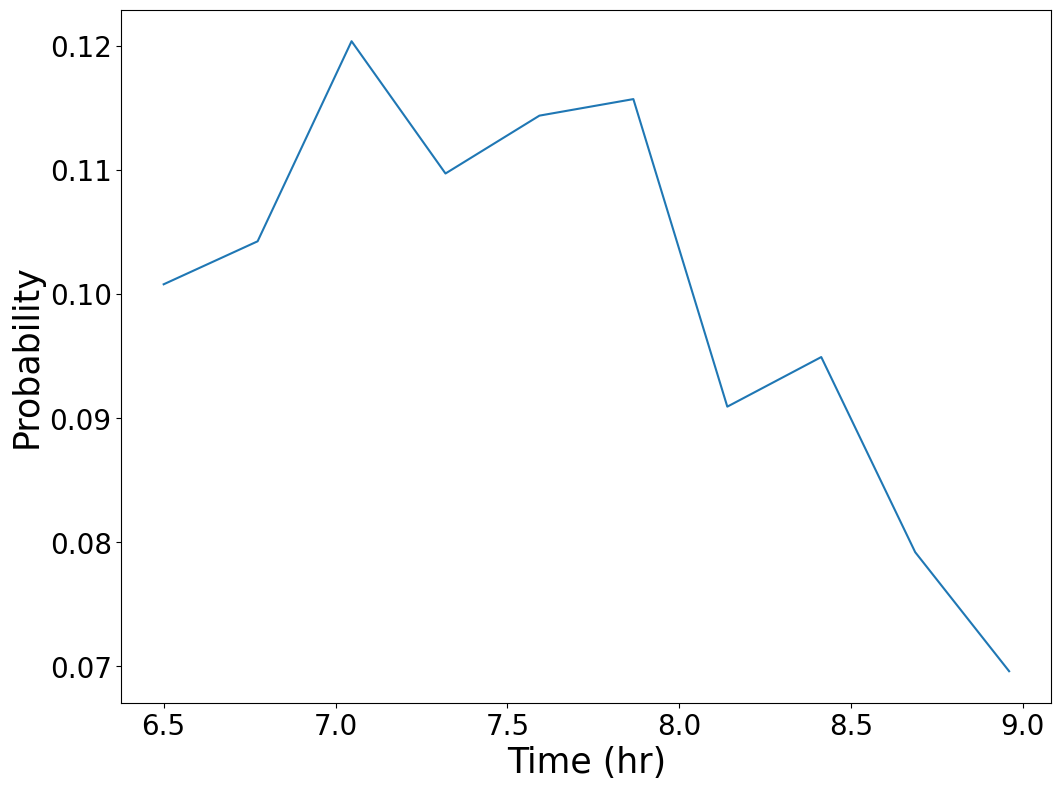

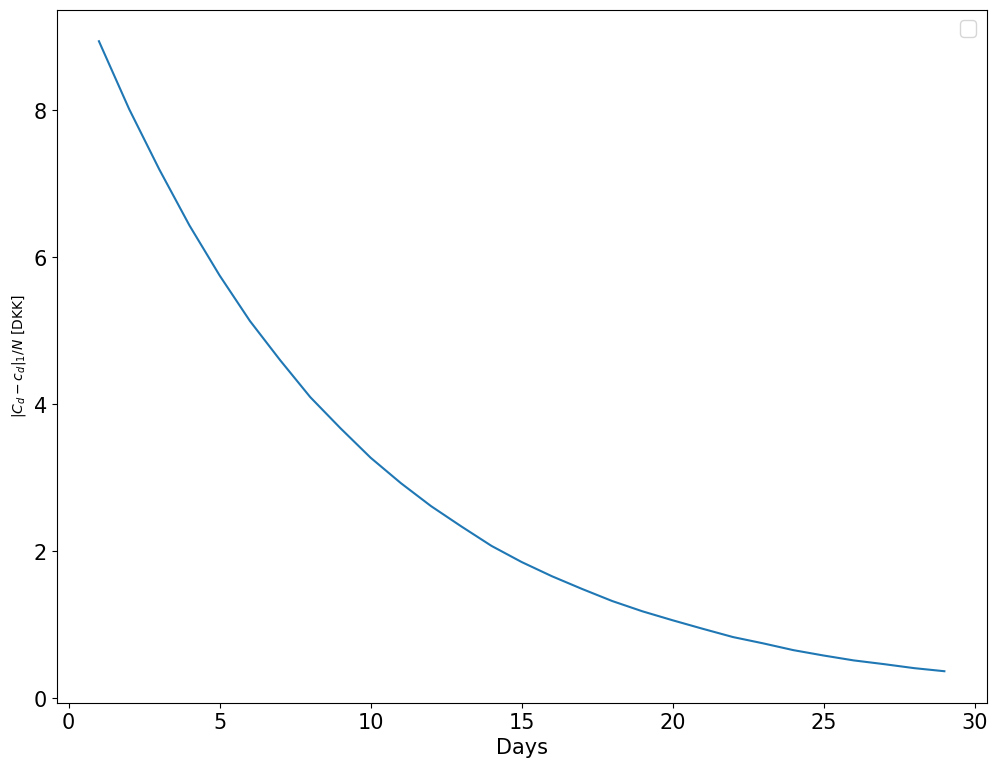

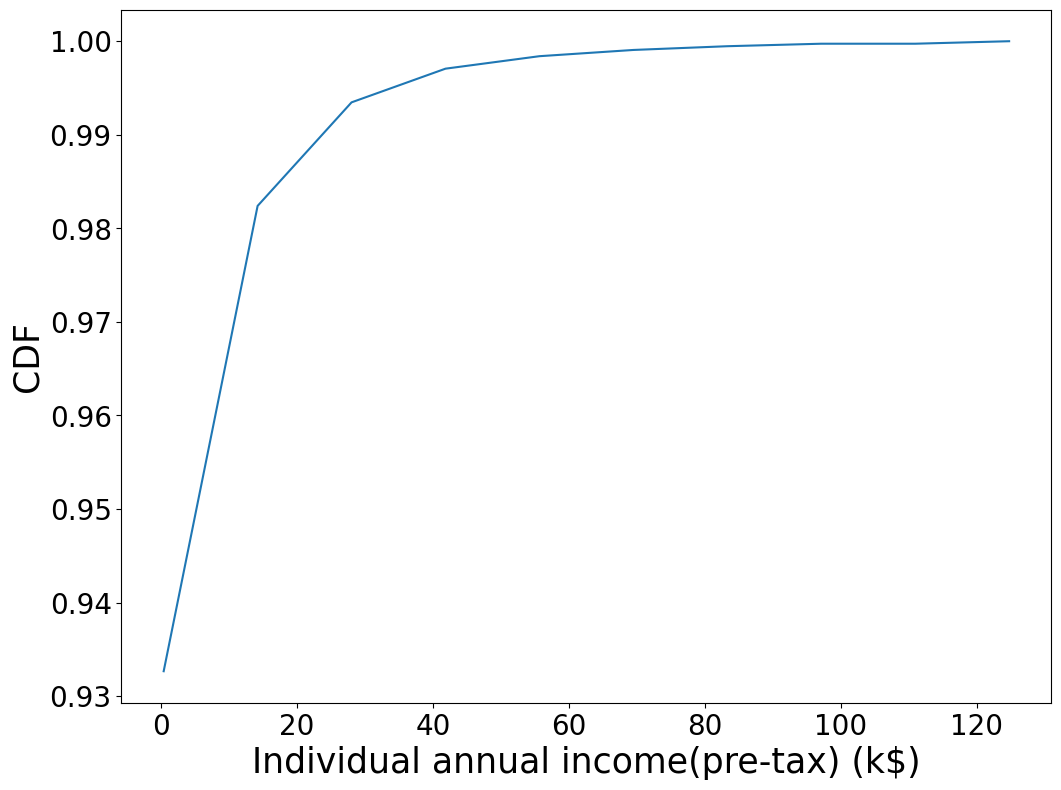

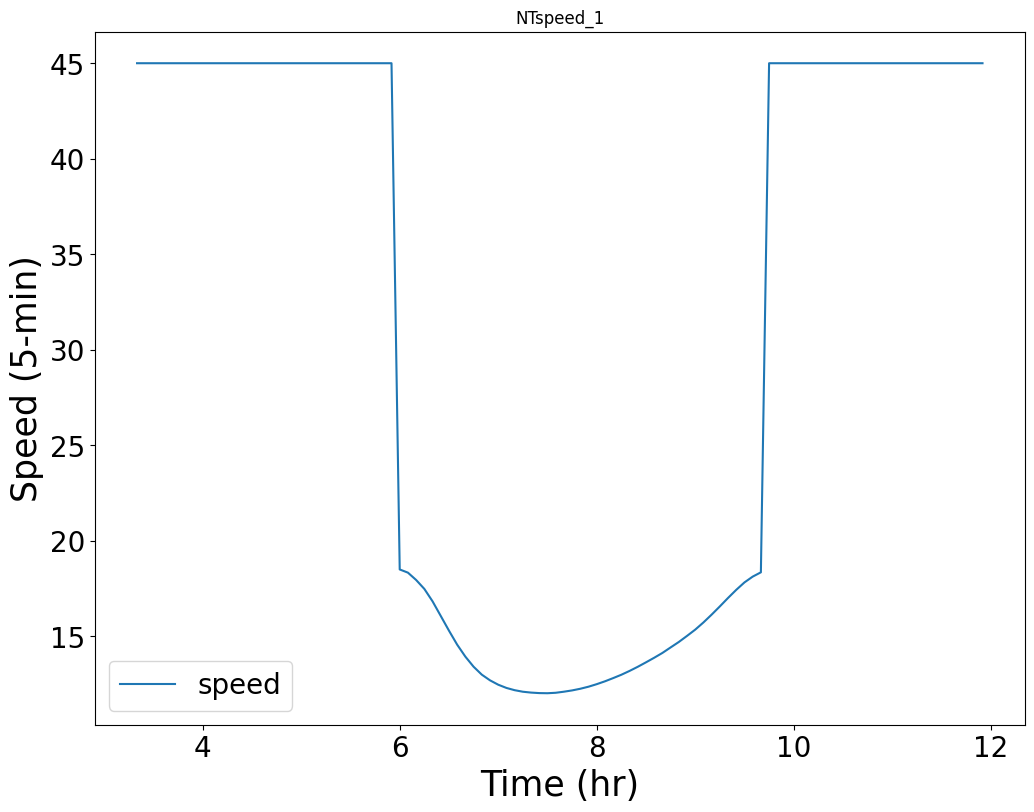

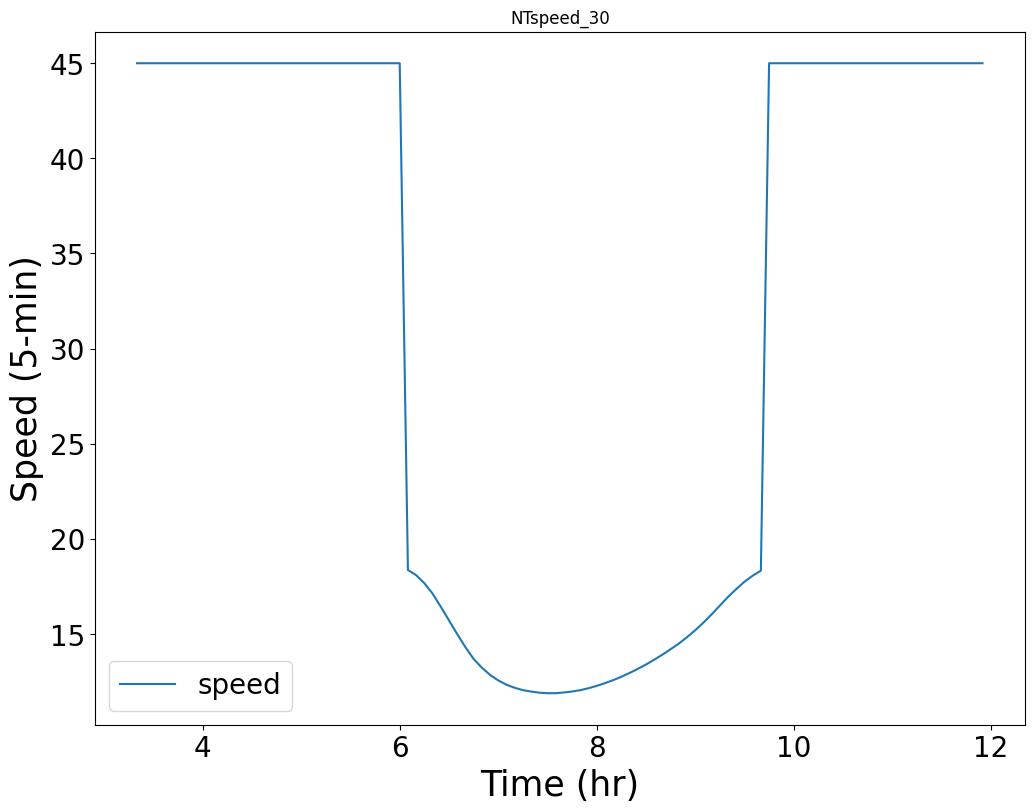

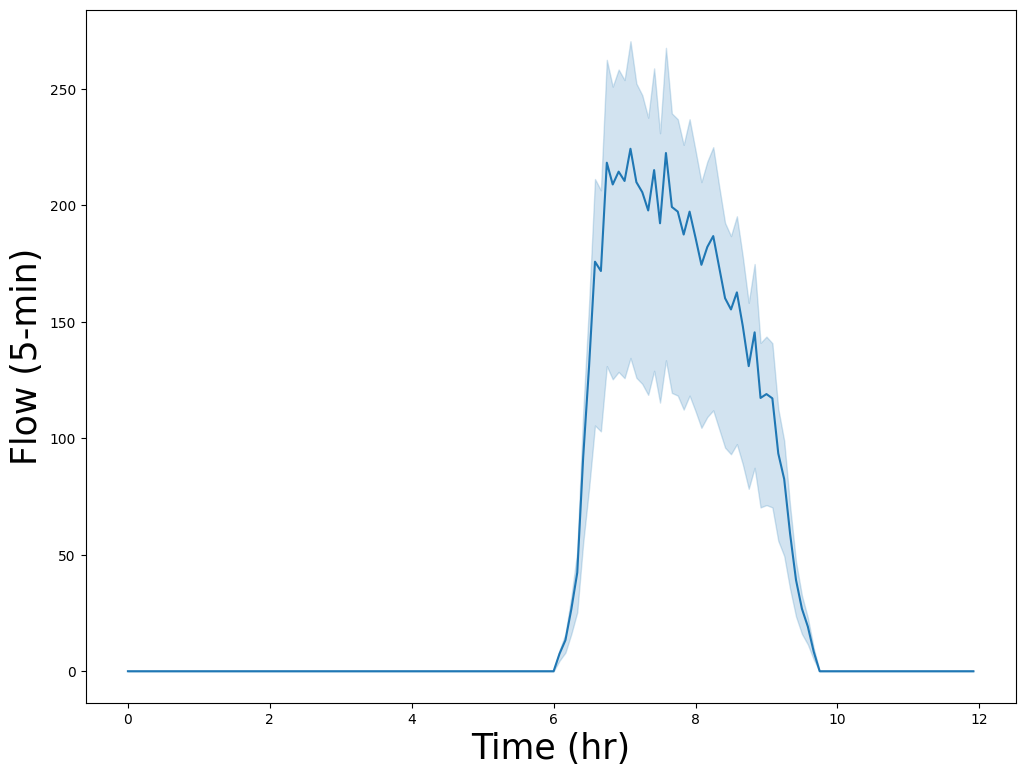

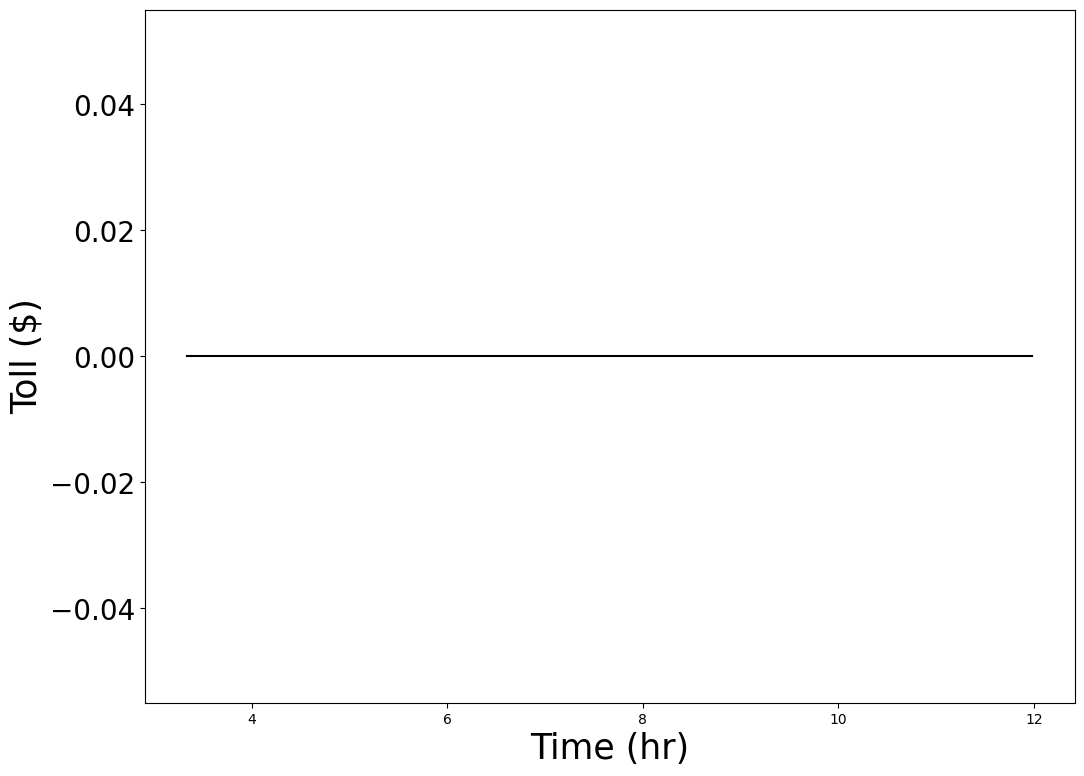

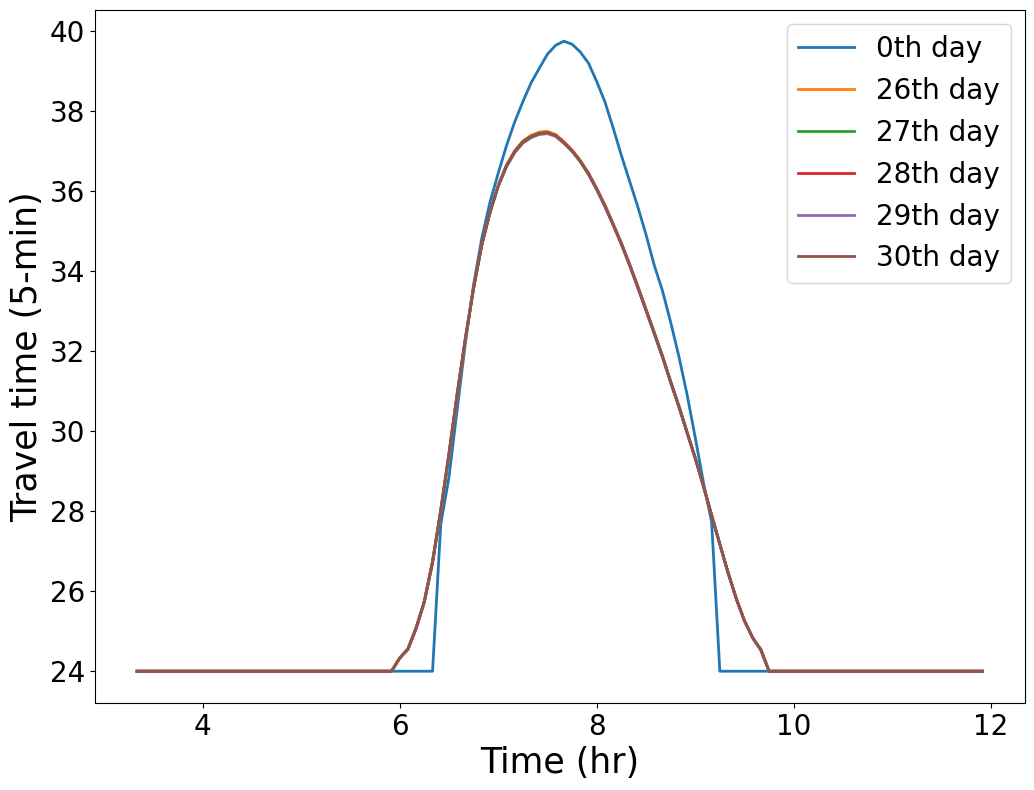

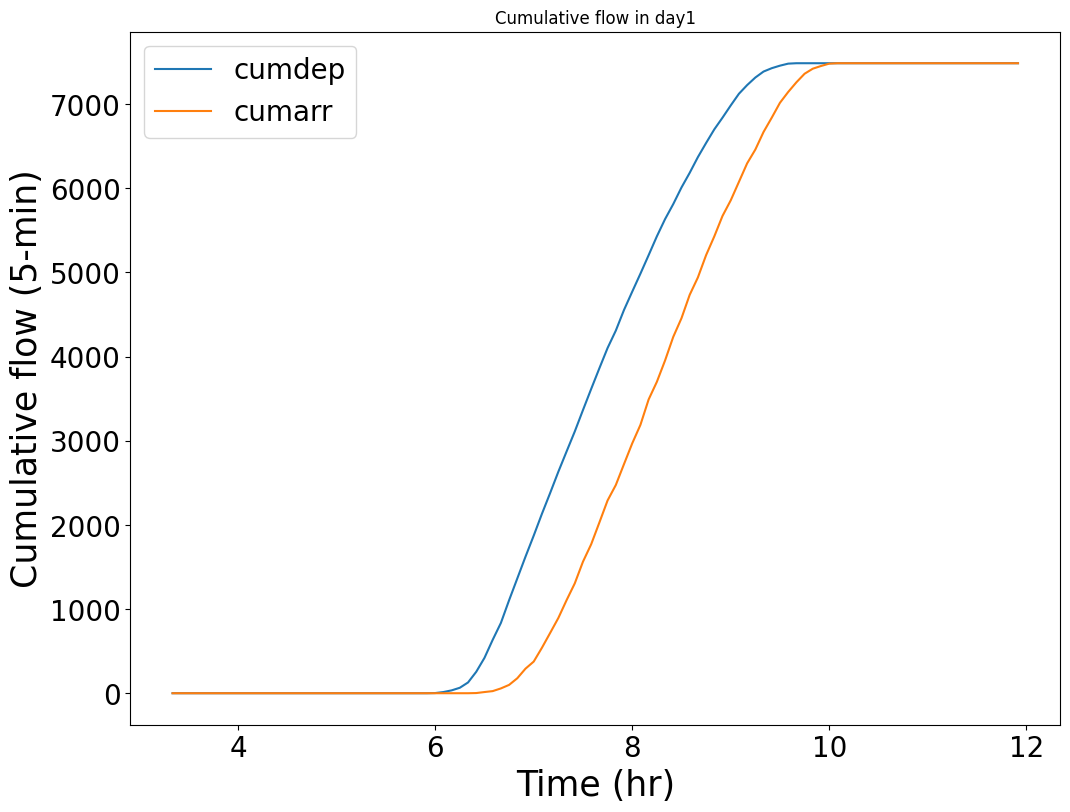

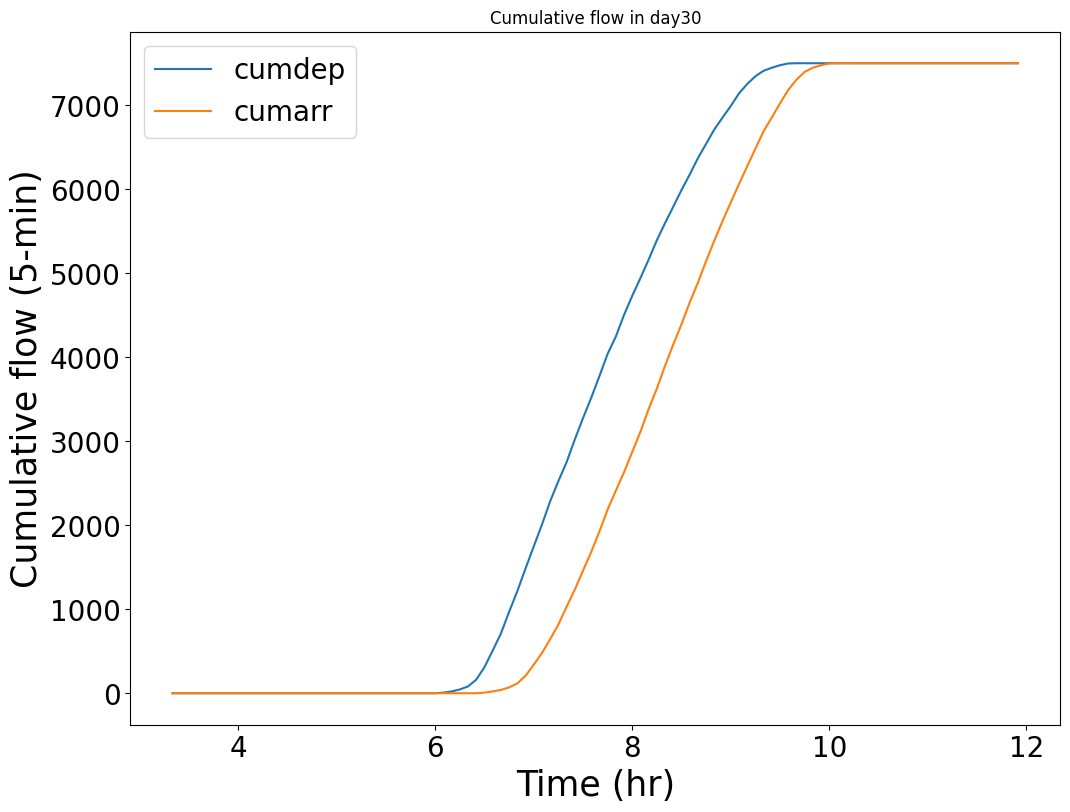

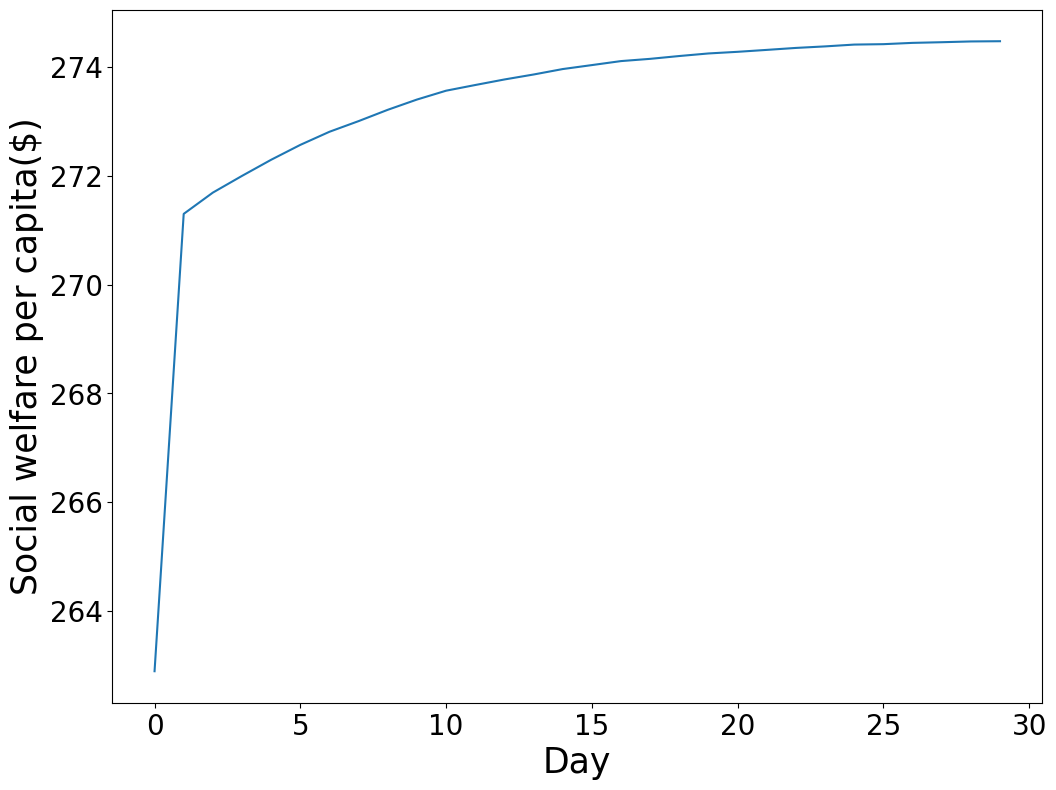

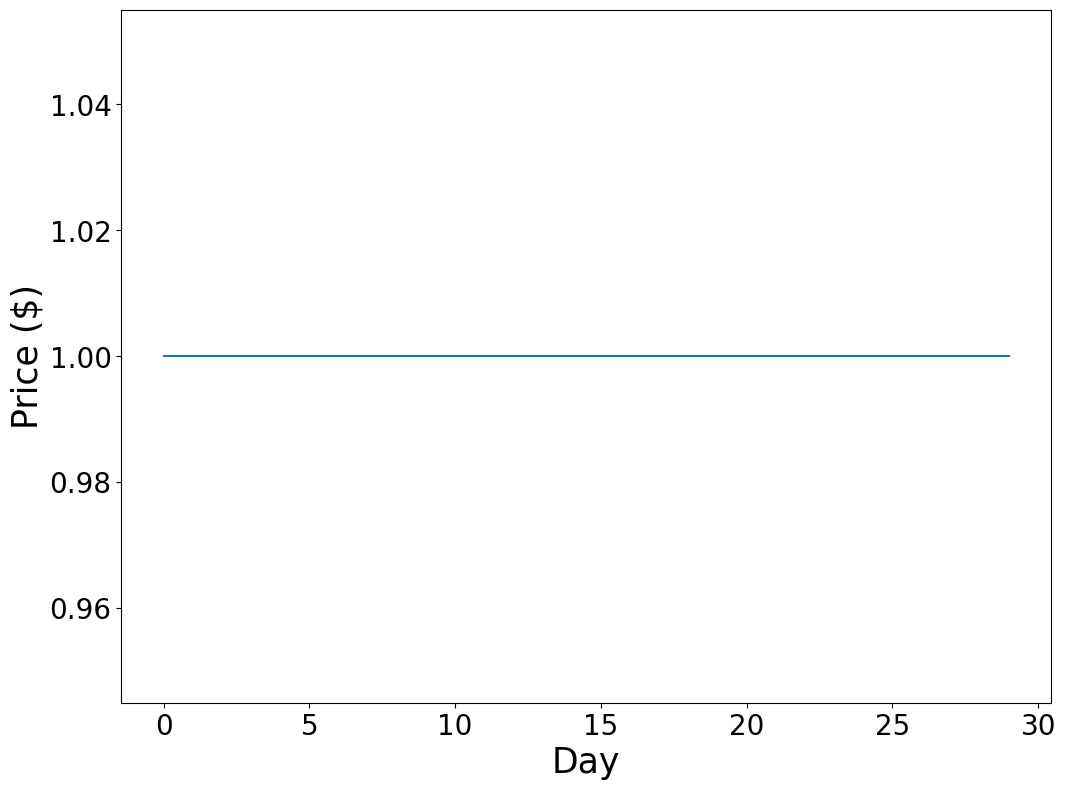

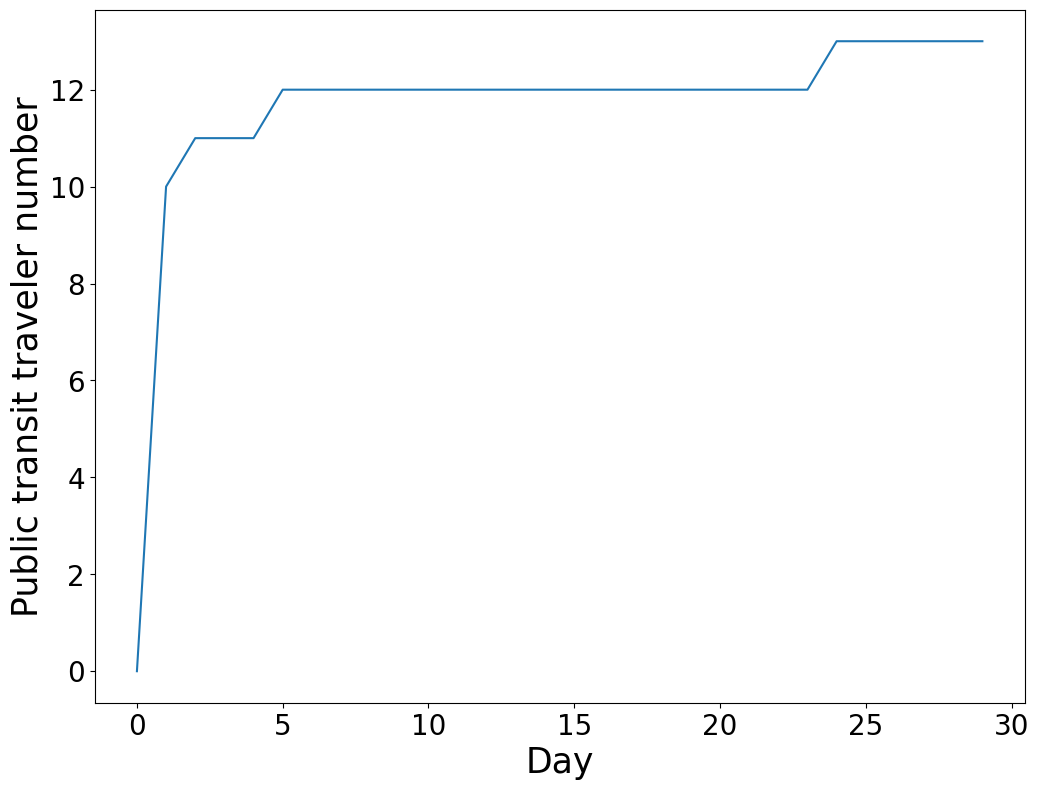

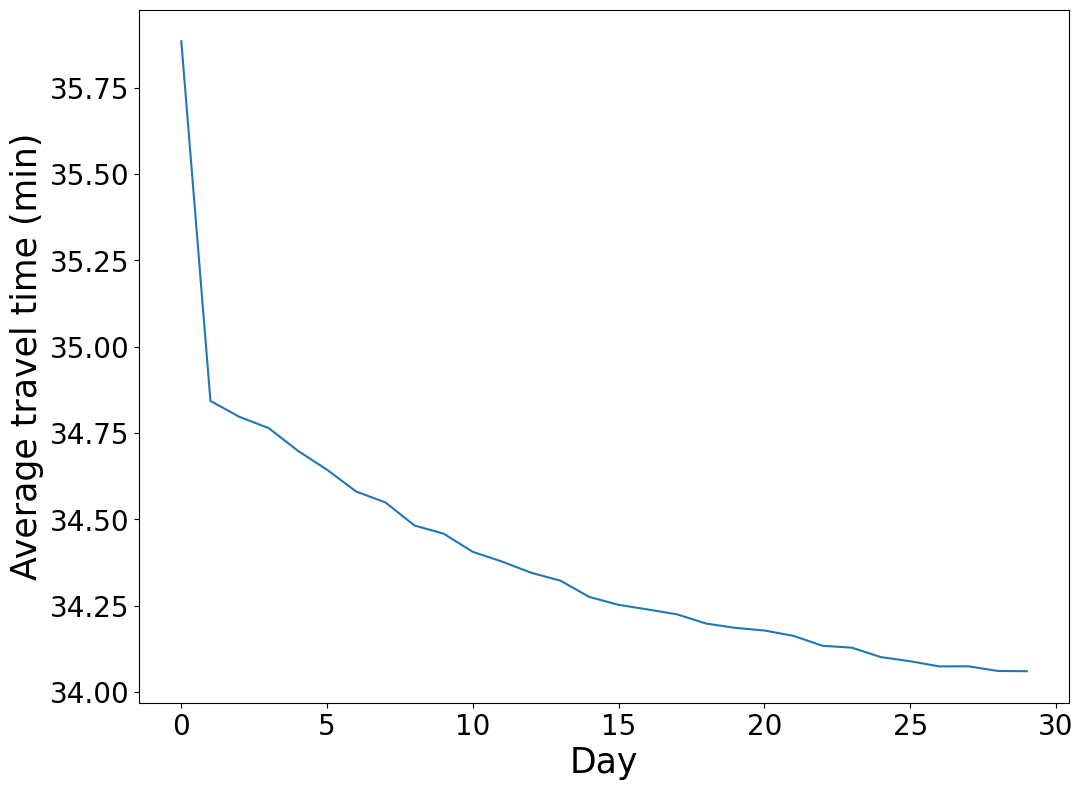

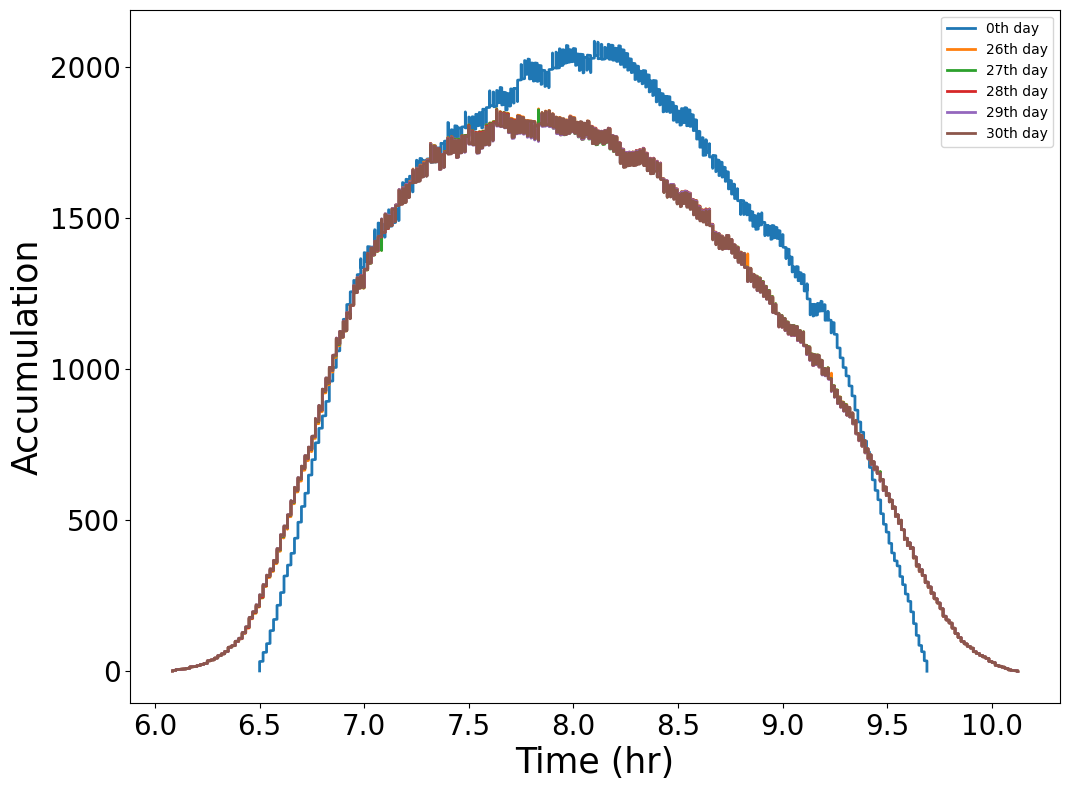

In [2]:
scenario = 'NT' # simulate:'NT': no toll, 'CP': congestion price, 'Trinity'
toll = 'normal' # 'step', 'normal'
tollparams = [(7.90084456*60-420)/120, (65.01906779-60)/10, (2.49667875-3)/2]
# only applies if scenario is Trinity
if scenario == 'Trinity':
    allocation = {'AR':0.00269,'way':'continuous','FTCs': 0.05,'FTCb':0.05,'PTCs': 0.00,'PTCb':0.00,"Decaying": False}
else:
    allocation = {'AR':0.0,'way':'lumpsum','FTCs': 0,'FTCb':0,'PTCs': 0,'PTCb':0,"Decaying":False}
if scenario == 'CP':
    allowance = {'policy': 'personalization','ctrl':1.125,'cap':float("inf")}
    #allowance = {'policy': 'uniform','ctrl':1.0291,'cap':7.4} # policy: "personalization" or "uniform"
    #allowance = {'policy': 'personalization','ctrl':1.0291,'cap':7.4}
else:
    allowance = {'policy': False,'ctrl':1.048,'cap':float("inf")}
marketPrice = 1

# only applies if scenario is Trinity
if scenario == 'Trinity':
    allocation = {'AR':0.00269,'way':'continuous','FTCs': 0.05,'FTCb':0.05,'PTCs': 0.00,'PTCb':0.00,"Decaying": False}
else:
    allocation = {'AR':0.0,'way':'lumpsum','FTCs': 0,'FTCb':0,'PTCs': 0,'PTCb':0,"Decaying":False}
CV = False
if scenario == 'NT':
    CV = False
print("Scenario: ", scenario, " Toll: ",  toll)

start_time = timeit.default_timer()
simulator = Simulation(_numOfdays= numOfdays, _user_params = user_params,
                        _scenario=scenario,_allowance=allowance, 
                        _marketPrice=marketPrice, _allocation = allocation,
                        _deltaP = deltaP, _numOfusers=numOfusers, _RBTD = RBTD, _Tstep=Tstep, 
                        _Plot = Plot, _seed = seed_Value, _verbose = verbose, 
                        _unusual = unusual, _storeTT=storeTT, _CV=CV, save_dfname='./output/MFD/NT/NT')
simulator.simulate(tollparams, iter, toll)
res = simulator.metrics()
elapsed = timeit.default_timer() - start_time
print(elapsed)
print(res)

Scenario:  Trinity  Toll:  normal
annual income ginit 0.567845856778155 remaining I gini 0.6187642849311471
 day  0
 day  1
 day  2
 day  3
 day  4
 day  5
 day  6
 day  7
 day  8
 day  9
 day  10
 day  11
 day  12
 day  13
 day  14
 day  15
 day  16
 day  17
 day  18
 day  19
 day  20
 day  21
 day  22
 day  23
 day  24
 day  25
 day  26
 day  27
 day  28
 day  29
numOfbindingI:  0 number of pt travel:  876
average tt:  32.004630295402336 average sde:  1.917270117406829 average SDL:  11.000540412809173 max TT:  43.199999999999996
average car tt:  30.524083214903012 average car sde:  2.1708221438030217 average SDL:  12.455322025372704 max TT:  43.199999999999996
nan user id: (array([], dtype=int64),)
welfare:  7379.442652929357 MCE:  7074.596250280809 full allowance:  0.0 full RR:  -191.67613800007894 full Toll revenue:  11208.858492000005
number of buying:  4470 number of selling:  3030 number of undesired:  0.0
original gini:  0.6187642849311471 current gini:  0.6176977859887424
NT u

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


percetange positive benefit:  0.5613333333333334
424.7898261551745
{'obj': 7379.442652929357, 'objcv': 0, 'Tollcollected': 11208.858492000005, 'ntgini': 0.6187642849311471, 'gini': 0.6176977859887424, 'grpcv': array([0., 0., 0., 0., 0.]), 'grpmce': array([ 1.28638843,  0.41013746, -0.19772876,  0.38292543,  5.3669822 ]), 'avgtt': 32.004630295402336, 'avgsde': 1.917270117406829, 'avgsdl': 11.000540412809173, 'RR': -191.67613800007894, 'ginicv': 0.6187642849311471, 'grpa': array([0., 0., 0., 0., 0.]), 'dataframe':        betavot  dailyincome    a       mce  utilbenefit         util  \
0     0.797749  1113.959161  0.0  5.784904     5.800456  1081.210023   
1     0.165118   202.969433  0.0  5.581504     5.663197   209.818505   
2     0.066859    61.477369  0.0  5.463308     5.721509    69.984212   
3     0.097843   106.094533  0.0  6.162909     6.333952   112.841856   
4     0.207093   263.414447  0.0  2.120470     2.144438   264.771087   
...        ...          ...  ...       ...        

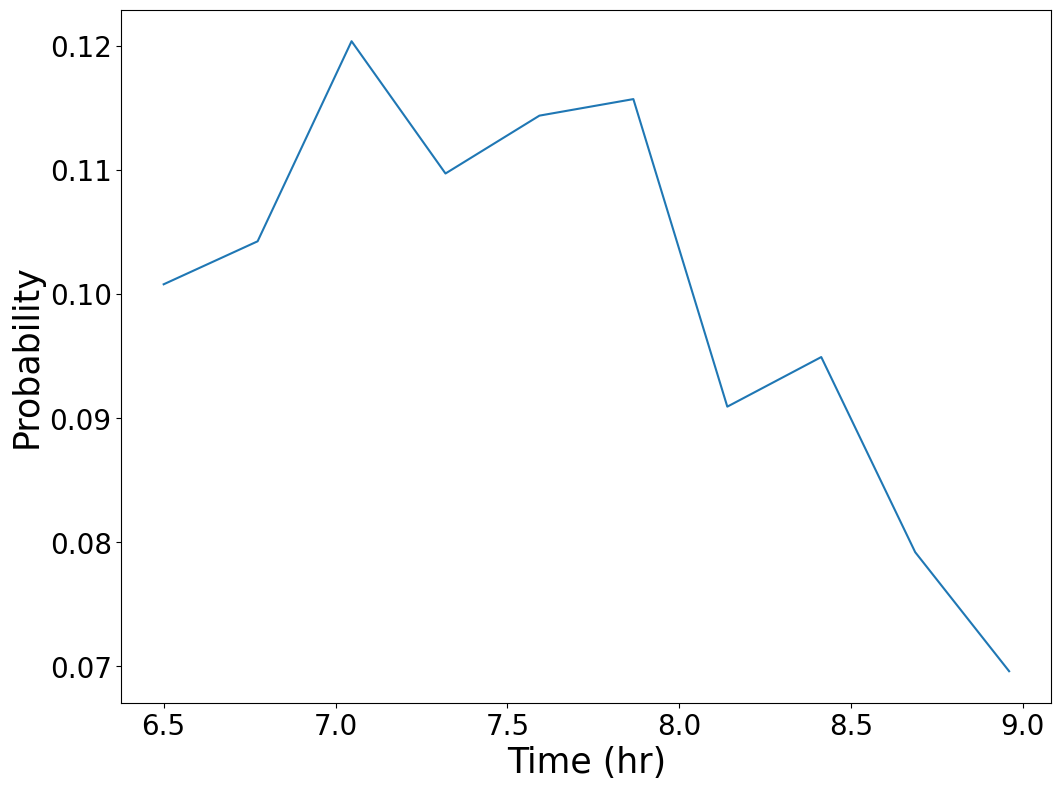

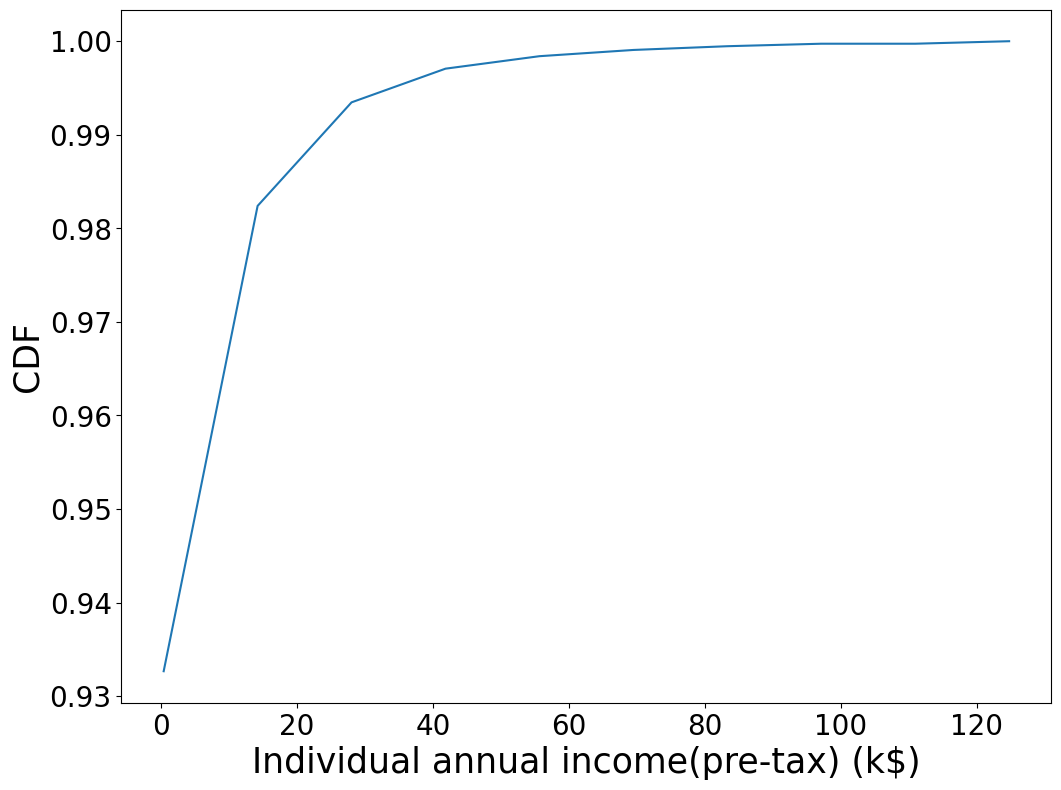

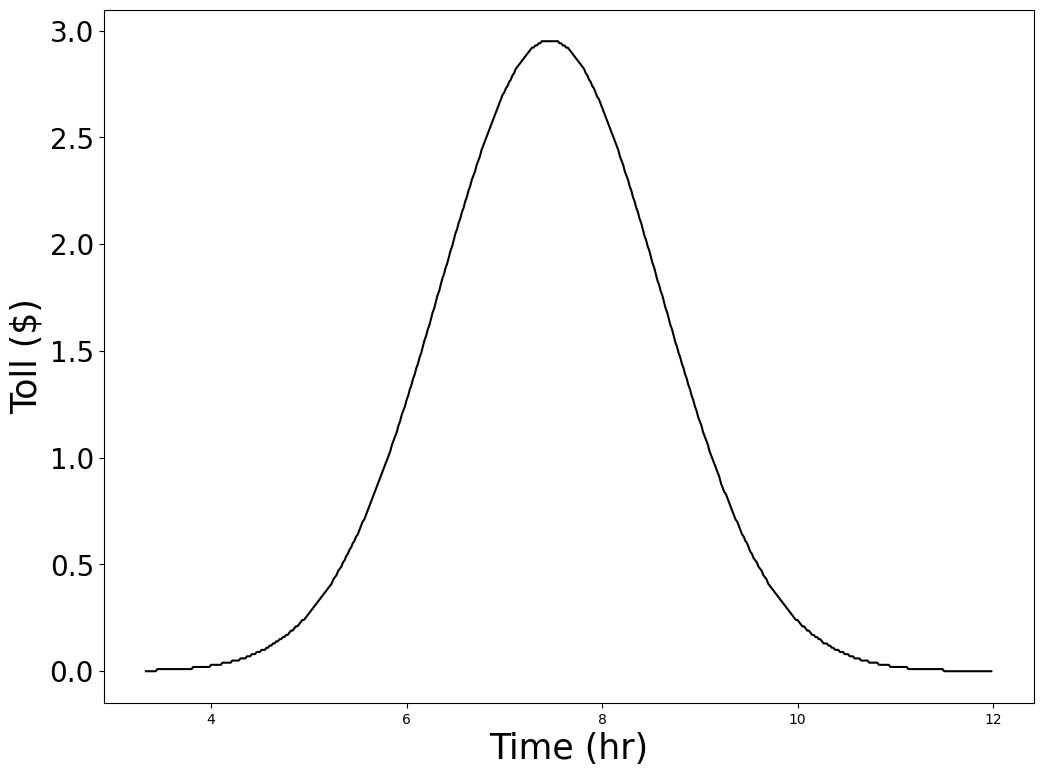

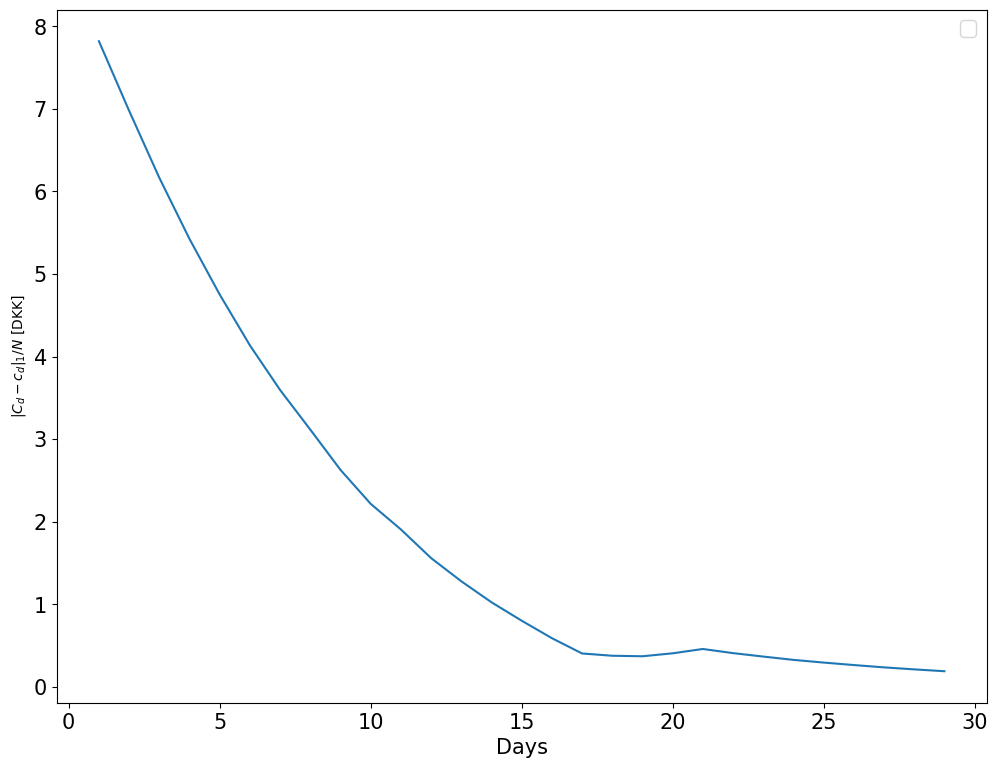

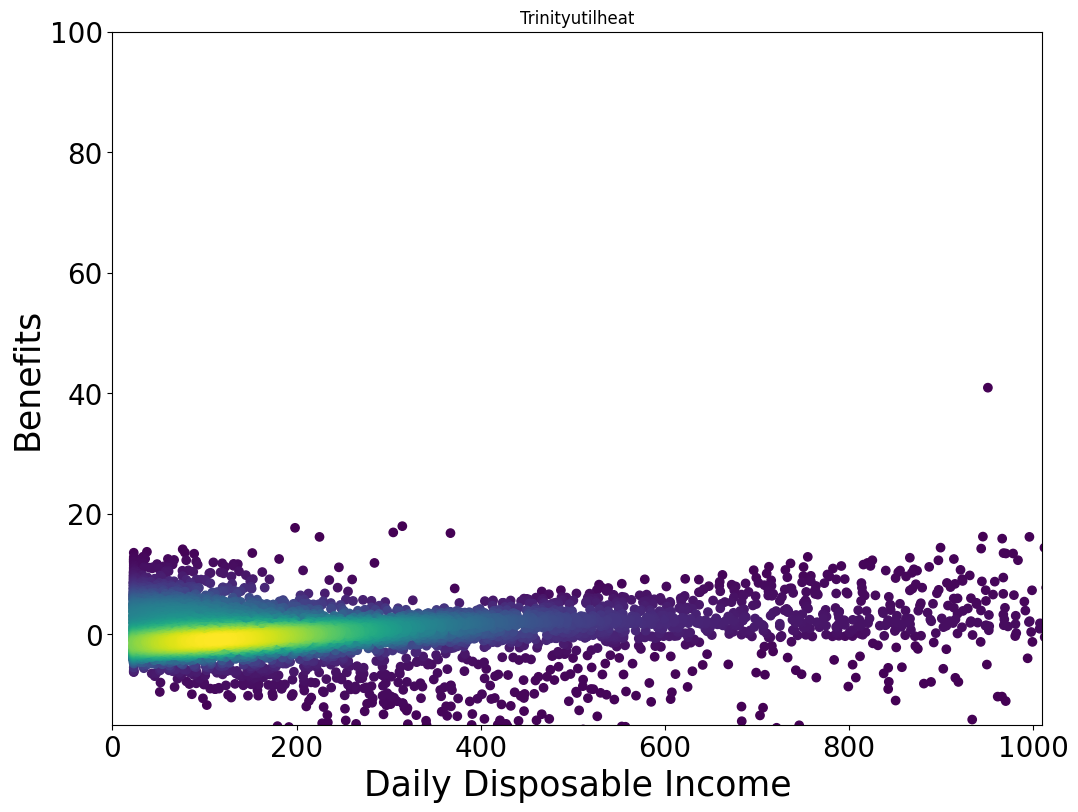

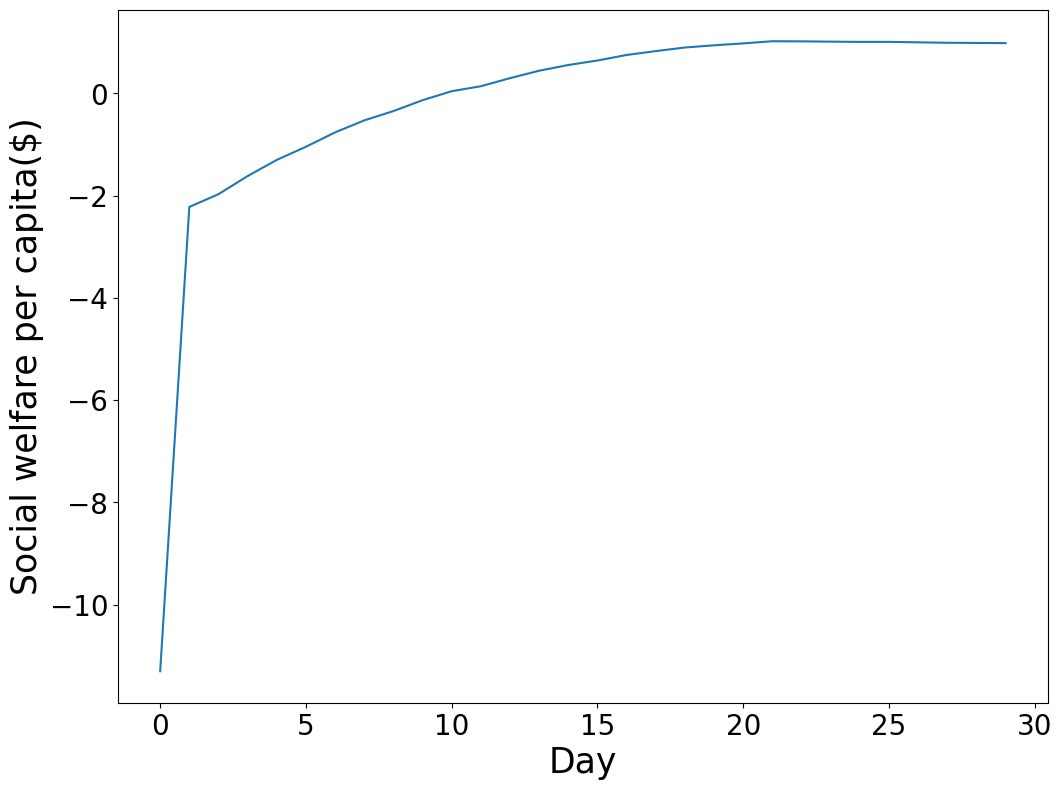

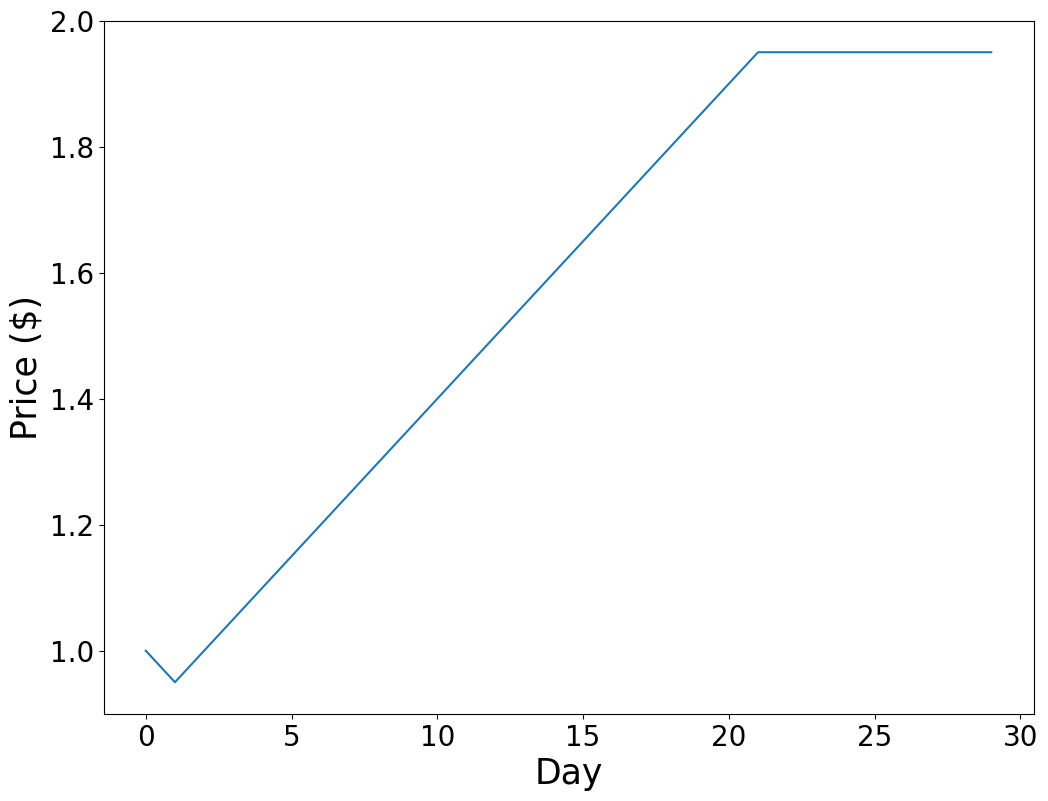

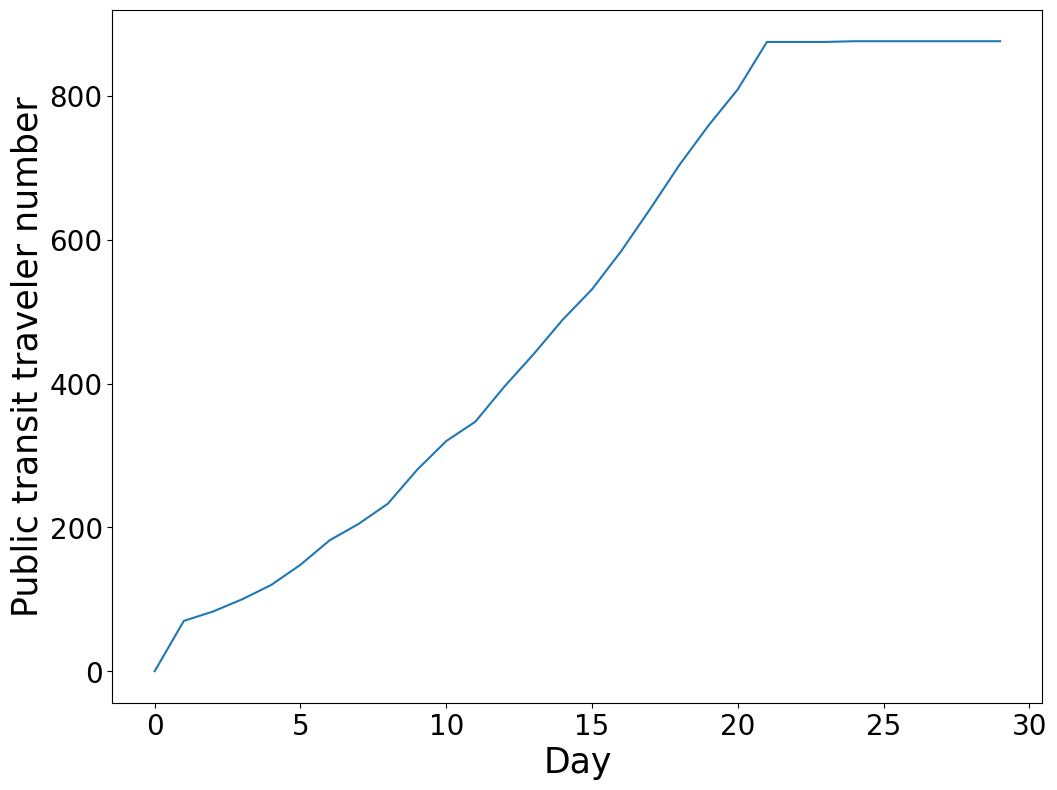

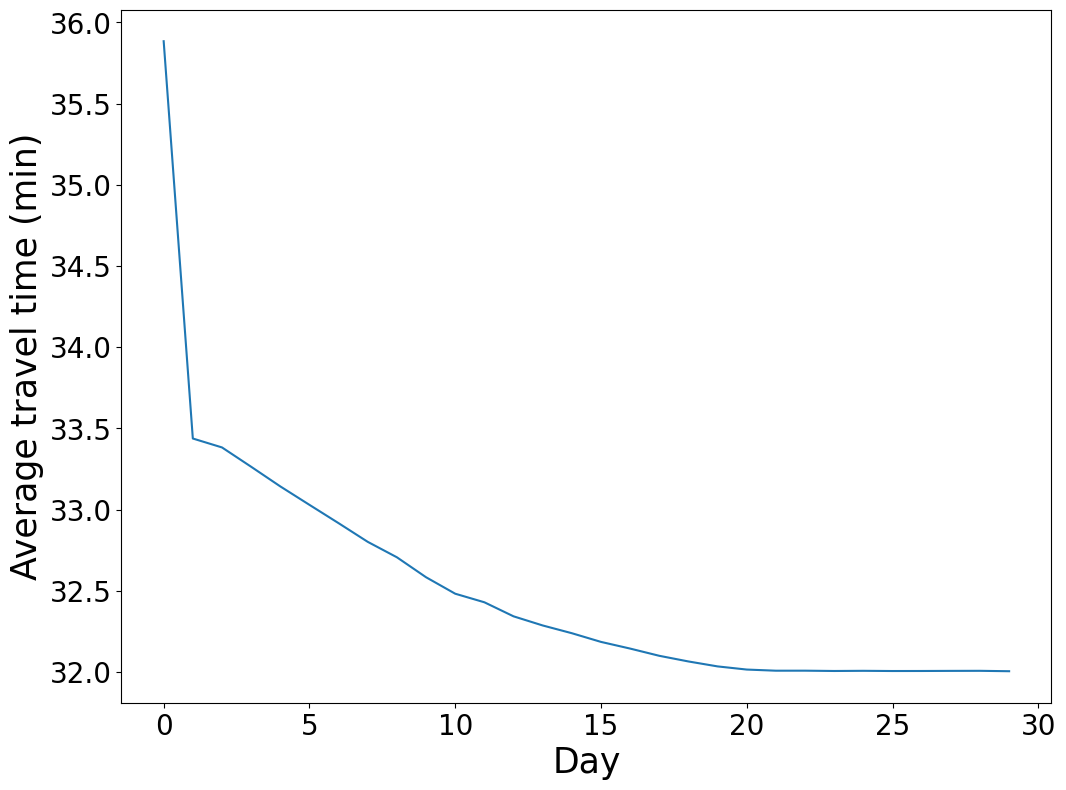

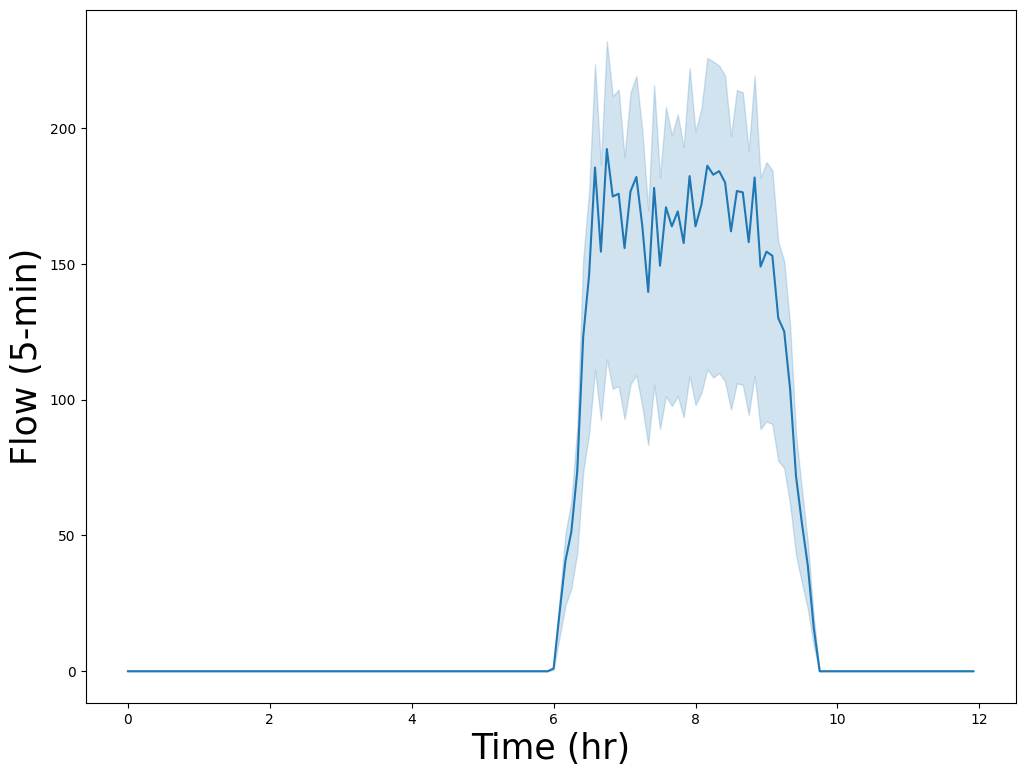

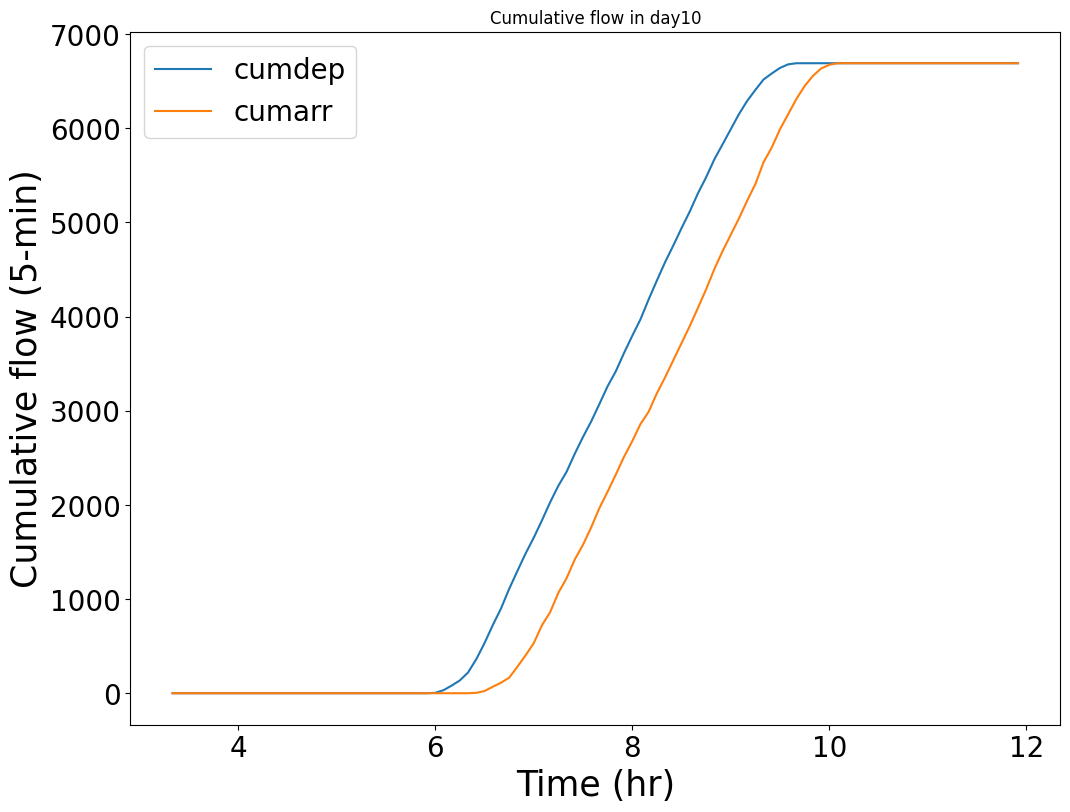

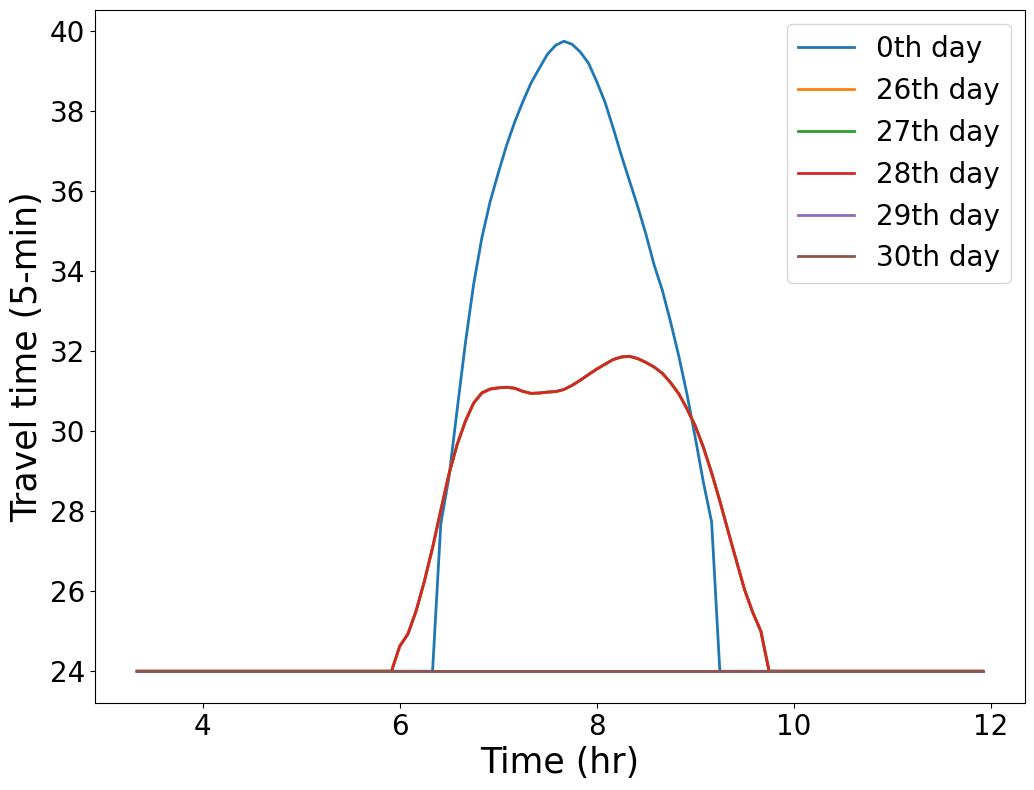

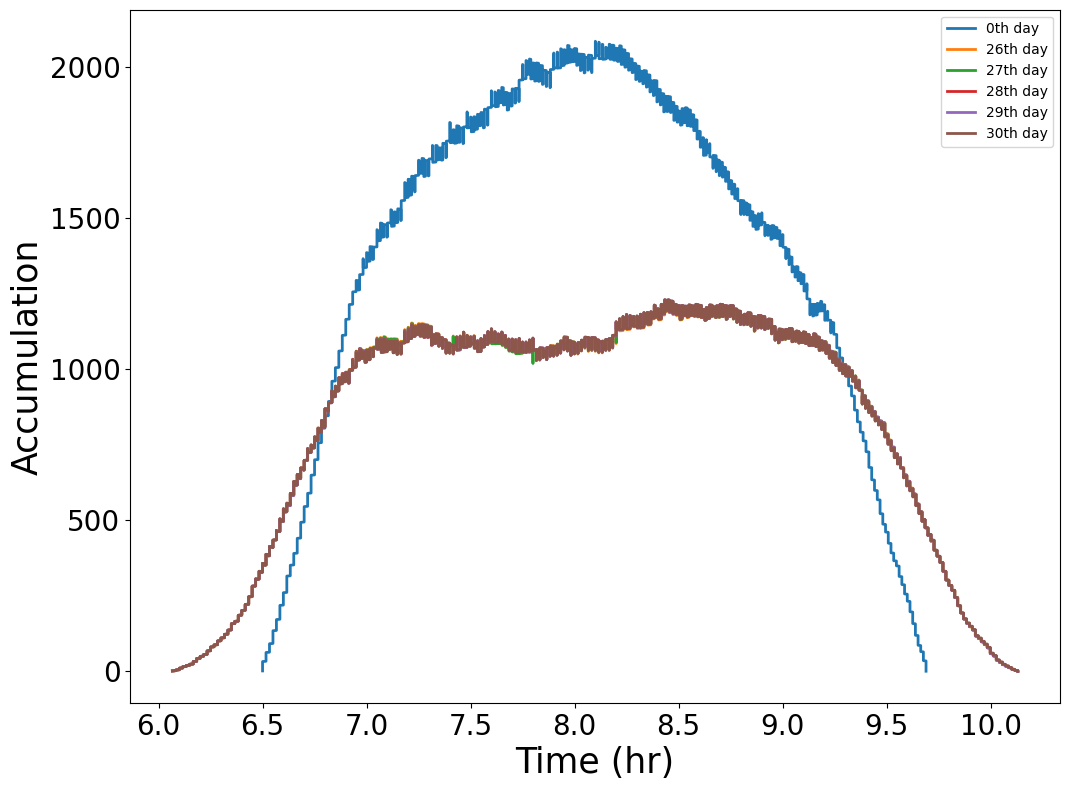

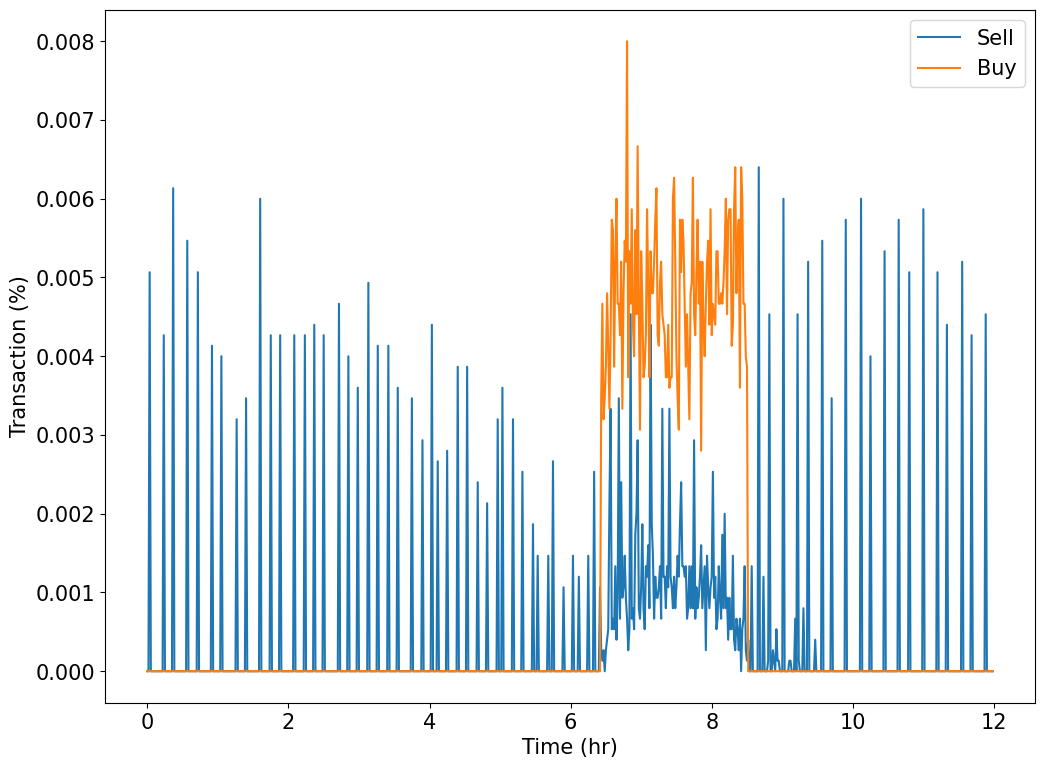

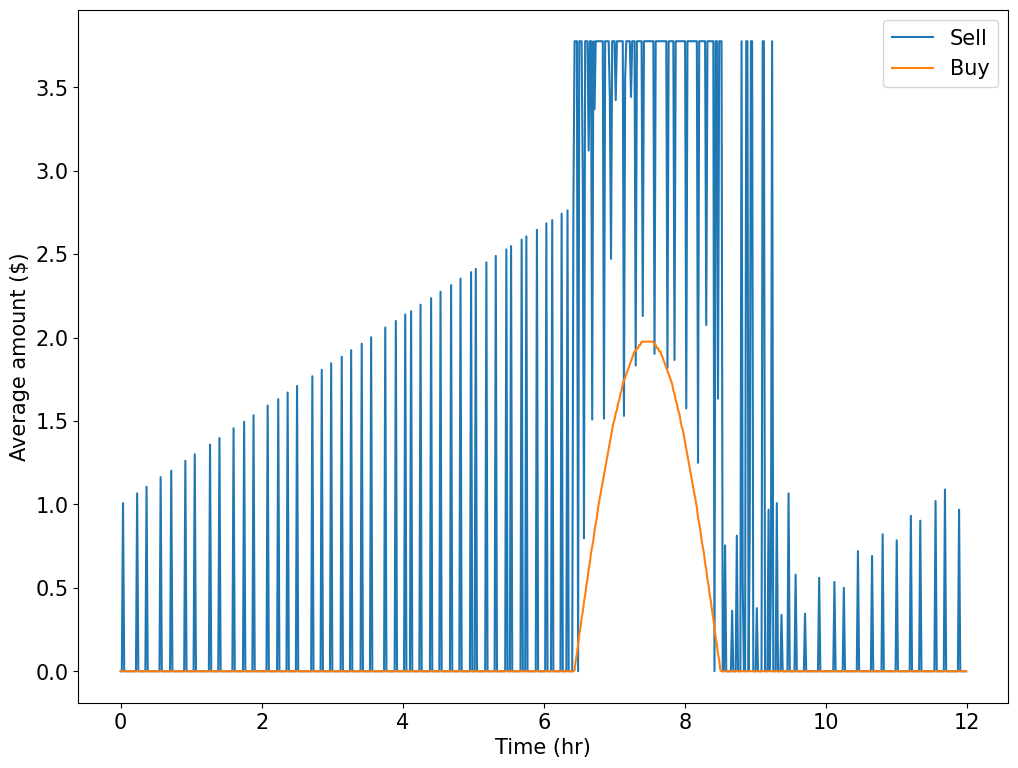

In [3]:
tollparams = [ 0.23321407,  0.76213885, -0.02265058]
scenario = 'Trinity' # simulate:'NT': no toll, 'CP': congestion price, 'Trinity'
toll = 'normal' # 'step', 'normal'
# only applies if scenario is Trinity
if scenario == 'Trinity':
    allocation = {'AR':0.00269,'way':'continuous','FTCs': 0.05,'FTCb':0.05,'PTCs': 0.00,'PTCb':0.00,"Decaying": False}
else:
    allocation = {'AR':0.0,'way':'lumpsum','FTCs': 0,'FTCb':0,'PTCs': 0,'PTCb':0,"Decaying":False}
if scenario == 'CP':
    allowance = {'policy': 'personalization','ctrl':1.125,'cap':float("inf")}
    #allowance = {'policy': 'uniform','ctrl':1.0291,'cap':7.4} # policy: "personalization" or "uniform"
    #allowance = {'policy': 'personalization','ctrl':1.0291,'cap':7.4}
else:
    allowance = {'policy': False,'ctrl':1.048,'cap':float("inf")}
marketPrice = 1
# only applies if scenario is Trinity
if scenario == 'Trinity':
    allocation = {'AR':0.00269,'way':'continuous','FTCs': 0.05,'FTCb':0.05,'PTCs': 0.00,'PTCb':0.00,"Decaying": False}
else:
    allocation = {'AR':0.0,'way':'lumpsum','FTCs': 0,'FTCb':0,'PTCs': 0,'PTCb':0,"Decaying":False}
CV = False
if scenario == 'NT':
    CV = False
print("Scenario: ", scenario, " Toll: ",  toll)
start_time = timeit.default_timer()
simulator_trinity = Simulation(_numOfdays= numOfdays, _user_params = user_params,
                        _scenario=scenario,_allowance=allowance, 
                        _marketPrice=marketPrice, _allocation = allocation,
                        _deltaP = deltaP, _numOfusers=numOfusers, _RBTD = RBTD, _Tstep=Tstep, 
                        _Plot = Plot, _seed = seed_Value, _verbose = verbose, 
                        _unusual = unusual, _storeTT=storeTT, _CV=CV, save_dfname='./output/MFD/Trinity/Trinity')
simulator_trinity.simulate(tollparams, iter, toll)
res = simulator_trinity.metrics()
elapsed = timeit.default_timer() - start_time
print(elapsed)
print(res)